# PHYS20762 - Project - Monte Carlo Particle Simulation

Joseph Bateman<br>
University of Manchester  
April 2021

# Monte Carlo Particle Simulation

Monte carlo simulations are modelling techniques used to determine expected outcomes and properties of systems through repeated random sampling. It is particularly effective at modelling systems with many possible paths, such as random walks of particles, a feature which is used in this project [1]. 

Thermal neutrons describe a group of neutrons with a kinetic energy around 0.025 eV. They are known as thermal neutron because it is the most likely energy for a neutron to have at 290 K, about room temperature.

Thermal neutrons passing through a material interact with the atoms in two main ways, each with a different liklihood of occurance. An neutron, when an interaction with an atom occurs, will either be scattered in a new direction, losing a portion of its energy, or it will be completely absorbed [2]. In a good thermal neutron shield, the majority of incident neutrons will be absorbed, or reflected back towards the source, protecting the other side of the shield from a bombardment of neutrons. A good shield is required in places such as nuclear reactors, where technicians and other staff would otherwise be very vulnerable to neutron radiation. This radiation can create unstable isotopes within bodily tissue, or break chemical bonds and change cell functionality, causing long term and prolonged damage [3].

This project seeks to compare three different materials to determine the most appropriate shielding material, using Monte Carlo modelling techniques. To do this, an appropriate source of random numbers needs to be found, which will then be used to sample from a probability distribution to model the random path of a neutron in one of the materials. Repeating this many times will mean the expected distance a neutron travels  in each material can be determined & compared to make a decision on the optimal choice.

First of all, the initial parameters of the notebook are imported, as well as the known properties of each of the three materials:
1. Water
2. Lead
3. Graphite

The density of each material is taken to be at STP, and the mass, absorption, and scattering coefficients used are those determined for thermal neutrons, as they vary with order of magnitude of neutron energy. The National Institute of Standards and Technology (NIST) have a wealth of these experimentally determined values [4] which were used.

In [1]:
### Note that if the notebook is set to run through completely, plots will not appear in figure boxes until the last cell
### complete, which may take time due to later calculations. This can be avoided by stopping cells 26-30 and 
### re-running cells with unrendered plots, or waiting for the notebook to completely finish (about 5 minutes).

%matplotlib notebook
from IPython import display
import matplotlib.pyplot as plt
from scipy.stats import maxwell
from scipy.optimize import curve_fit
import numpy as np

### Defining the initial formatting of the plots
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.figsize"] = (9,6)
plt.rc('xtick', labelsize=6) 
plt.rc('ytick', labelsize=6)
plt.style.use('default')
# Creating an array of formatting types for clarity & consistency
colours = ("r", "g", "b", "y", "c", "m", 
           "tab:pink", "tab:olive", "tab:purple", "tab:orange", "tab:red") 

In [2]:
### Defining the thermal neutron properties of water, lead, and graphite
density_lead = 11.35 # g/cm^3
density_water = 1.00 # g/cm^3
density_graphite = 1.67 # g/cm^3

mass_lead = 207.2 # amu
mass_water = 18.01528 # amu
mass_graphite = 12.011 # amu

absorb_lead = 0.158 # barn, 10^-28 m^2
absorb_water = 0.6652 # barn
absorb_graphite = 0.0045 # barn

scatter_lead = 11.221 # barn
scatter_water = 103.0 # barn
scatter_graphite =  4.74 # barn

lead = ([density_lead, mass_lead, absorb_lead, scatter_lead])
water = ([density_water, mass_water, absorb_water, scatter_water])
graphite = ([density_graphite, mass_graphite, absorb_graphite, scatter_graphite])
matter = ([lead, water, graphite])
names = (["Lead", "Water", "Graphite"])

# Defining Some Random Number Generators

As mentioned before, a reliable random number generator is required for Monte Carlo modelling. It is very difficult to find a readily usable random number generator, so more often pseudo random number generators are instead used, which output statistically random strings of numbers. However, given the initial parameters, every step can be determined. 

Two random number generators will be considered, the RANDSSP Multiplicative congruential generator (based upon the linear congruential generator), and the Mersenne Twister, used in the numpy library as numpy.uniform.random(). Plotting these as arrays in 3D, so-called hyperplanes will looked for, inicating a strong correlation between consecutive values in 3D space, which may not be obvious in lower dimensions. This kind of correlation would mean a random number generator was not suitable for Monte Carlo.

In [3]:
### Defining the RANDSSP generator, which returns an array of random numbers of dimensions p-by-q. Random numbers are created 
### using X_(n+1) = (aX_n + c) mod(m). The first value inputted X_0 is known as the seed.
def randssp(p,q): 

    global m, a, c, x
        
    try: x
    except NameError:
        m = pow(2, 31)
        a = pow(2, 16) + 3
        c = 0
        x = 123456789
    
    try: p
    except NameError:
        p = 1
    try: q
    except NameError:
        q = p
    
    r = np.zeros([p,q])

    for l in range (0, q):
        for k in range (0, p):
            x = np.mod(a*x + c, m)
            r[k, l] = x/m
    
    return r

Before finding hyperplanes, a 1d distribution will be quickly considered. A histogram is plotted below, with the expectation value of each bin and the and 1 standard deviation error. A uniform distribution  is binomial, but for large sample sizes it can be approximated to a gaussian distribution. This makes the error far easier to compute and the difference becomes negligible. As sample size is increased, each bin will tend towards the expected size and the error will decrease relatively, as $\sigma \approx \sqrt{a}$, where $a = \frac{n}{no.  of bins}$. A series of increasingly large sample sizes will be compared to assess the large n approximation.

<IPython.core.display.Javascript object>


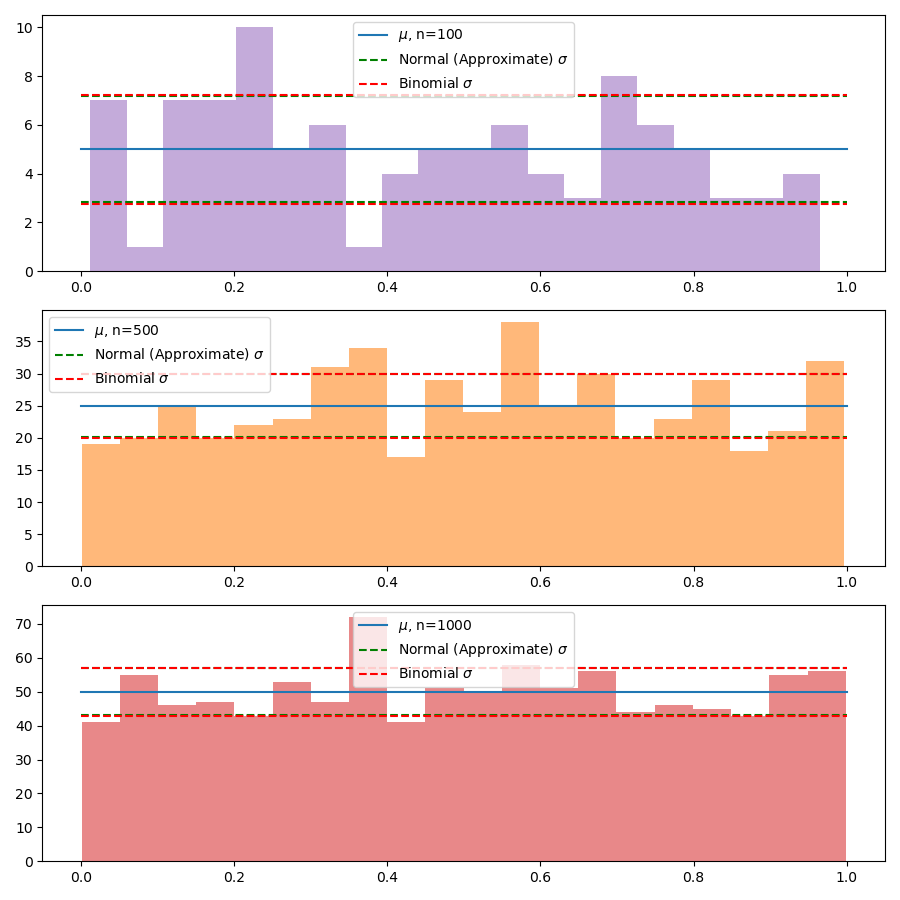

In [4]:
sample_size = 100, 500, 1000
r = [[np.random.uniform() for i in range(sample_size[0])], [np.random.uniform() for i in range(sample_size[1])],
     [np.random.uniform() for i in range(sample_size[2])]]


fig, ax = plt.subplots(3,1)
fig.set_size_inches(9,9)

for i in range(3):
    k=sample_size[i]*1/20
    sigma = np.sqrt(k) # Error from normal distribution
    std = np.sqrt(k*(1-1/20)) # Error from binomial

    ax[i].hist(r[i], 20, color=colours[i+8], alpha = 0.55)
    ax[i].plot([0,1], [k,k])
    ax[i].plot([0,1], [k+std,k+std], "g--", [0,1], [k+sigma,k+sigma], "r--")
    ax[i].plot([0,1], [k-std,k-std], "g--", [0,1], [k-sigma,k-sigma], "r--")
    ax[i].legend(["$\mu$, n={}".format(sample_size[i]),"Normal (Approximate) $\sigma$", "Binomial $\sigma$"])
fig.tight_layout()    

At large sample sizes, it does appear that np.random.uniform() will return a uniform distribution, and the normal approximation is appropriate even at the n=100 sample size. Now, issues with translating these plots to 3D will be examined, in particular hyper planes.

In [5]:
sample_size = 1000
### Generating a random number set with np.random.uniform()
xnumpy = np.random.uniform(0,1, sample_size)
ynumpy = np.random.uniform(0,1, sample_size)
znumpy = np.random.uniform(0,1, sample_size)

### Setting the initial parameters of the RANDSSP generator
m=2**32
a= pow(2, 16) + 3
c=0
x=123456789
k = randssp(3, sample_size)
xssp = k[0,:]
yssp = k[1,:]
zssp = k[2,:]

<IPython.core.display.Javascript object>


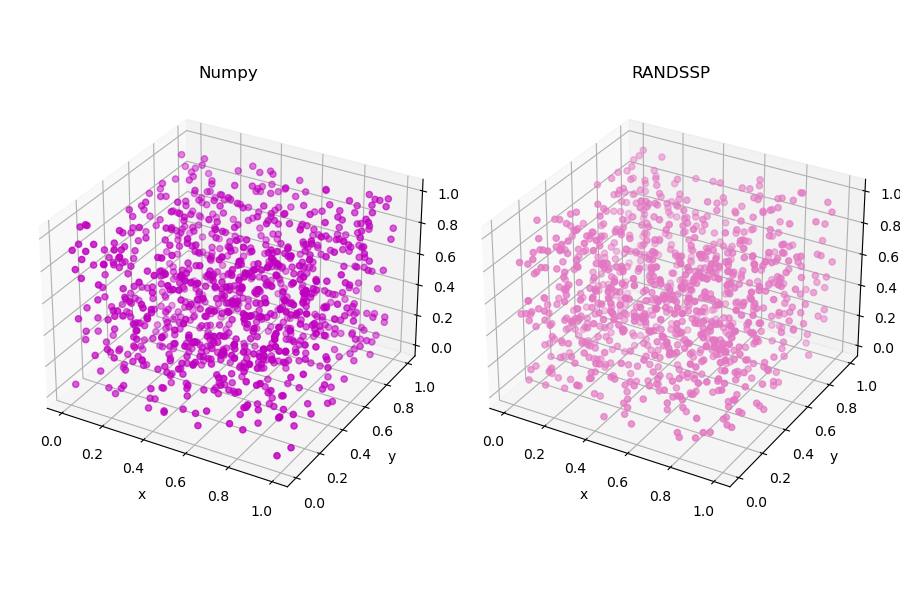

In [6]:
### Formatting the 3D plots of each random number generator
### To interact with the figure, left-click and drag on the plot of interest. Hold right click and move the mouse up
### to zoom out, and pull back to zoom in
fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

ax1.scatter(xnumpy, ynumpy, znumpy, color=colours[5])
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
ax1.set_title("Numpy")

ax2.scatter(xssp, yssp, zssp, color=colours[6])
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')
ax2.set_title("RANDSSP")

fig.tight_layout()

In the RANDSSP plot (the second) at $\phi = -90, \theta = 100$,  a series of equidistant planes appear, the hyperplanes of the algorithm. The mersenne twister however does not have this issues and is the one to be used further.

# Probability Distribution Sampling

Now a reliable random number generator has been found, a method to sample from a distribution needs to be established, and there are several ways to do this. The two considered in this project are:
1. The von Neumann method, where random numbers x and y are paired together, and f(x), the distribution function, is compared to y. If y < f(x), the pair is accepted, else it is rejected.
2. An inverse CDF, where the cumulative distribution function is identified and the inverse taken. Inputting uniform random numbers into this function will return a data set distributed according to the function.

The probability of a path length x is defined by an exponential function, $f(x) = \lambda e^{\frac{x}{\lambda}}$, where $\lambda$ is the mean free path of the neutron in the chosen material. This is found using $\sum_j^T n_j\sigma_j = \frac{1}{\lambda}$ [5], where n is number density of the interacting particle and $\sigma$ is the microscopic cross-section of the interaction. In this project only neutron-atomic interactions are considered, so we can simplify the sum to $n\sum_j^T\sigma_j = \frac{1}{\lambda}$. We will first only consider neutron absorption, so T=1 and only the microscopic absorption cross-sections are considered, but later scattering will also be accounted for.

$CDF = 1 - e^{\frac{x}{\lambda}} = y$, so  $CDF^{-1}=-\lambda ln(1-y)$. As the PDF $f(x)$ is normalized, $0<y<1$, so $1-y$ can be substituted for a uniform random number $0<z<1$, to give a random sample taken from $f(x)$.

In [7]:
### Defininging the inverse CDF, where l is the mean free path. Inputting a series of unifrom random numbers between
### 0 and 1 will give an exponentially distributed random sample.
def exponential_dist(x, l):
    return -(l)*np.log(x)

In [8]:
### Function to find the mean free path of a neutron considering only scattering and absorption. The molecular mass is assumed
### to be inputted in amu, and microscopic cross sections in barns. The density is assumed to be in g/cm^3.
def mean_free_path(density, molecular_mass, absorb, scatter):
    amu = 1.6605 * 10 ** (-24) # g
    barn = 10 ** (-24) # cm^2
    n = density/ (molecular_mass * amu) # cm^-3
    return 1/(n*absorb*barn + n*scatter*barn )

### Comparing the Methods

Intuitively, the von Neumann method appears to be far less effective at creating a sample as a significant portion of the sample will not be included in the final distribution. However, von Neumann's method is very helpful when an inverse CDF is undefined, or the PDF is multivalued, as a numerical solution is required.

In this case we do have an inverse, but the effectiveness of von Neumann's method is compared for different, larger sample sizes.

<IPython.core.display.Javascript object>


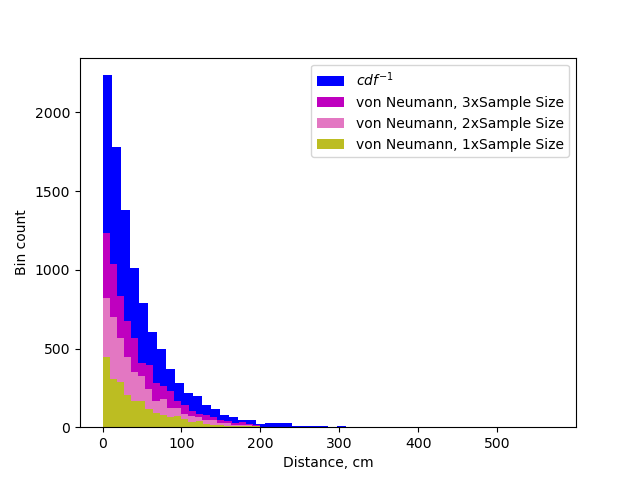

The acceptance rate is 0.225 for 3 times the cdf sample size
The acceptance rate is 0.223 for 2 times the cdf sample size
The acceptance rate is 0.22 for 1 times the cdf sample size


Text(0, 0.5, 'Bin count')

In [9]:
sample_size = 10000
mean_free = mean_free_path(density_water, mass_water, absorb_water, 0)

### Using an inverse CDF to create a random distribution sampled from an exponential distribution
z = [np.random.uniform() for i in range(sample_size)]
s = exponential_dist(z, mean_free)
fig, ax =  plt.subplots(1,1)
ax.hist(s, 50,color=colours[2])

### Creating the same function sample with the von Neumann method, with 1, 2, and 3 times the CDF sample size
for j in range(3):
    accepted=0
    tally=0
    dist = []
    sample = (3-j)*sample_size
    x = [200*np.random.uniform() for i in range(sample)]
    y = [1/(mean_free)*np.random.uniform() for i in range(sample)]
    for i in range(sample):
        if y[i] <  (1/mean_free)*np.exp(-x[i]/mean_free):  
            dist.append([x[i]])        
            accepted += 1

    rate = accepted/sample        
    print("The acceptance rate is {:.3} for {} times the cdf sample size".format(rate ,3-j))
    dist = np.asarray(dist)
    ax.hist(dist, 22, color=colours[j+5])
    
ax.legend(["$cdf^{-1}$", "von Neumann, 3xSample Size", "von Neumann, 2xSample Size", "von Neumann, 1xSample Size"])
ax.set_xlabel("Distance, cm")
ax.set_ylabel("Bin count")


Sampling x values from 0 to 200 in the von Neumann method, we see the technique to have an acceptance rate of about 22%. This highlights another limitation of the von Neumann method, that a finite range of x and y inputs must be used. As our function is normalized, the limit on y is not an issue, but on the axis no value greater than x=200 can possible be outputted. It would be expected that by increasing the x limit, the rejection rate would increase dramatically and, while this would make the distribution more accurate, the efficiency would decrease dramatically. This is demonstrated below, for the same sample size over an increasing range.

<IPython.core.display.Javascript object>


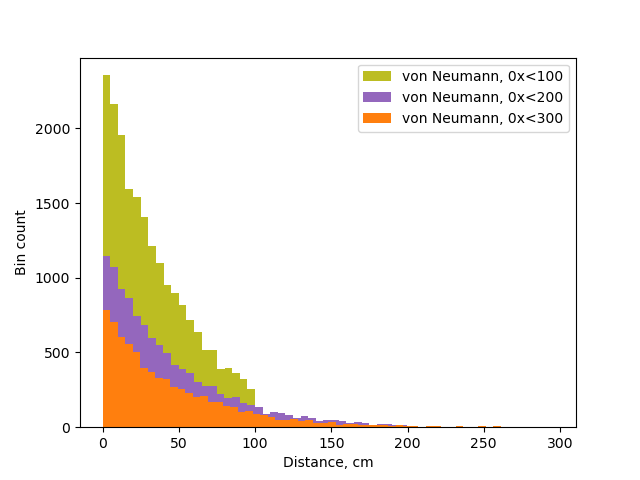

The acceptance rate is  0.40226 for 0<x<100
The acceptance rate is  0.22184 for 0<x<200
The acceptance rate is  0.147 for 0<x<300


Text(0, 0.5, 'Bin count')

In [10]:
fig, ax =  plt.subplots(1,1)

sample_size = 50000
mean_free = mean_free_path(density_water, mass_water, absorb_water, 0)

### Creating 3 von Neumann samples over different ranges to compare the number of accepted values returned
for j in range(3):
    accepted=0
    tally=0
    dist = []
    x = [(j+1)*100*np.random.uniform() for i in range(sample_size)]
    y = [1/(mean_free)*np.random.uniform() for i in range(sample_size)]
    for i in range(sample_size):
        if y[i] <  (1/mean_free)*np.exp(-x[i]/mean_free):  
            dist.append([x[i]])        
            accepted += 1

    print("The acceptance rate is ", (accepted/(sample_size)), "for 0<x<{}00".format(j+1))
    dist = np.asarray(dist)
    ax.hist(dist, 20*(j+1), color=colours[j+7])
 
ax.legend(["von Neumann, 0x<100", "von Neumann, 0x<200", "von Neumann, 0x<300"])
ax.set_xlabel("Distance, cm")
ax.set_ylabel("Bin count")

While the von Neumann method has its advantages, in this context the inverse CDF method will instead be used as it returns more distributed values for the same sample size, and there is no noticable limitation on the maximum value given (there is a limit to the precision of double float integers, 15 digits, but this is comparatively negligible).

# Finding the Attenuation Length of Absorption

Now random samples can be taken from the neutron path distribution, we can consider the simple case of determining the attenuation length of neutrons in a material. 

The attenuation length is the expected distance a neutron will travel in a material before absorption, and is associated with the mean free path. However, when scattering is considered in later sections, the neutron will not necessarily be discarded once an interaction occurs. This means that the mean path between collisions will not be the mean path before discarding the neutron, so a new method is needed to determine the mean distance travelled through the material.

The simple case of pure absorption is considered first, to test the procedure and identify limitations. For each material, the mean free path is found and an exponential distribution is sampled according to the path. A 50 bin histogram is used, and the natural logarithm of the count if each bin is found. The taking a linear fit of this data, the gradient will be inversely proportional to the attenuation length, which would we would expect to be equal to the mean free path.

To determine the error in the attenuation, 10 repeated readings will be taken, and the variance of the runs will be taken to find the error in the mean. 

<IPython.core.display.Javascript object>


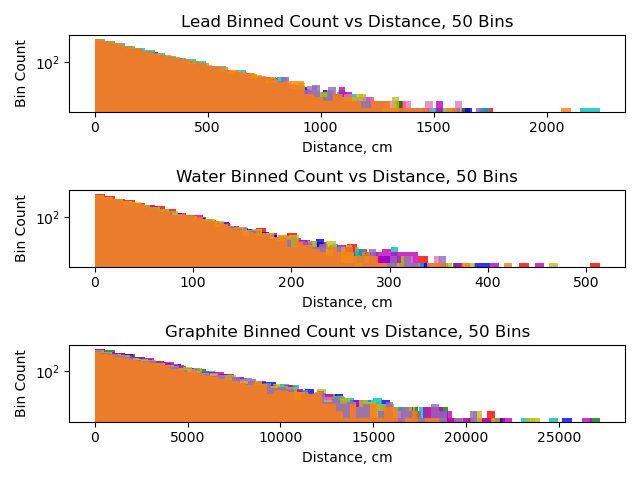

The expected mean free path for Lead is 191.85613115485415
The attenuation length of Lead  is 2.17e+02 +- 16.604056433982763 cm 
The expected mean free path for Water is 44.97049374624173
The attenuation length of Wate  is 50.7 +- 3.3949006019322168 cm 
The expected mean free path for Graphite is 2653.92754491018
The attenuation length of Grap  is 2.95e+03 +- 159.78195349014047 cm 


In [11]:
### Defining how much data will be processed, and how many size bins to make.
bin_number = 50
sample_size = 5000
runs = 10

fig,axs = plt.subplots(3,1)

### Taking 10 runs of 5000 neutrons for each material to find the attenuation length of absorption
for k, material in enumerate(matter):     
    attenuation = []
    mean_free = mean_free_path(material[0], material[1], material[2], 0)
    print("The expected mean free path for {} is {}".format(names[k], mean_free))
    for j in range(runs):
        z = [np.random.uniform() for i in range(sample_size)]
        s = exponential_dist(z, mean_free)
        f=[]
        x=[]
        hist, bins = np.histogram(s, bin_number)
        
        for i, value in enumerate(hist):
            if value != 0:
                x.append((bins[i]+bins[i+1])/2)
                f.append(np.log(value))
        
        axs[k].hist(s,bin_number, color=colours[j], alpha=0.8)
        coef= np.polyfit(x,f,1)
        attenuation.append(-1/coef[0])
    
    ### Formatting each plot
    axs[k].set_title("{} Binned Count vs Distance, {} Bins".format(names[k], bin_number))
    axs[k].set_yscale("log")
    axs[k].set_xlabel("Distance, cm")
    axs[k].set_ylabel("Bin Count")
    
    ### Finding the mean attenuation length and the associated error
    mean_attenuation =  np.mean(attenuation), np.std(attenuation)
    print("The attenuation length of {:.4}  is {:.3} +- {} cm ".format(names[k], mean_attenuation[0],mean_attenuation[1],"cm"))

fig.tight_layout()

Given that 5000 simulations are being repeated 10 times, we would expect the attenuation length to equal the mean free path, given the central limit theorem [6]. This however is not the case. We in fact observe a systematic overestimation of the mean free path, an issue which highlights the limitations of this method, because the fitting is weighted higher by extreme distance values. This can be accounted for with larger bin widths, but this also increases the error on the the gradient. A balance between bin number and sample size will need to be found, and the overestimation will have to be considered when scattering is included in calculations.

The number of particles considered in later calculations will be of the order of 1000, run 5 to 10 times. Taking the size to be 5000, run 10 times, bins of size 5, 10, 25, 50, 100, and 200 will be tested upon the same data, and the results compared.

The expected mean free path for lead is 44.97.


<IPython.core.display.Javascript object>


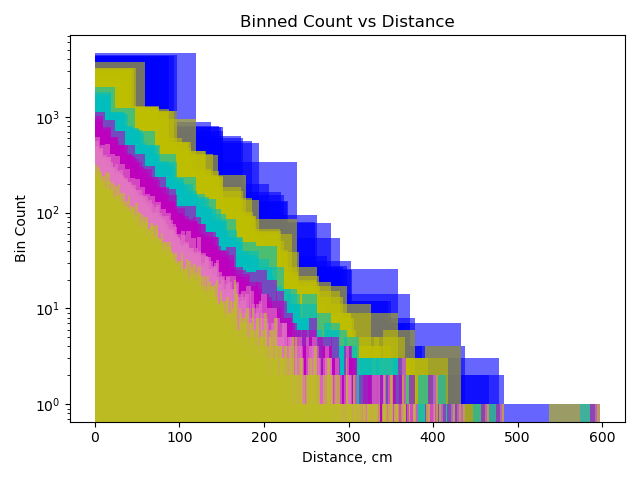

The attenuation length of water  is 48.03 +- 3.387 cm , with 5 bins
The attenuation length of water  is 49.33 +- 5.105 cm , with 10 bins
The attenuation length of water  is 50.81 +- 4.909 cm , with 25 bins
The attenuation length of water  is 52.54 +- 4.164 cm , with 50 bins
The attenuation length of water  is 54.37 +- 3.488 cm , with 100 bins
The attenuation length of water  is 56.79 +- 3.42 cm , with 200 bins


In [12]:
attenuation = []
test = ([density_water, mass_water, absorb_water, 0])
bin_number = ([5, 10, 25, 50, 100, 200])
sample_size = 5000
runs = 10

mean_free = mean_free_path(test[0], test[1], test[2], 0)
print("The expected mean free path for lead is {:.4}.".format(mean_free))

fig,axs = plt.subplots(1,1)

### Creating a single 10 run sample size for each bin size to use
u=[]
for j in range(runs):
    z = [np.random.uniform() for i in range(sample_size)]
    s = exponential_dist(z, mean_free)
    u.append(s)
 
### Determining the attenuation length for each bin size, and plotting the data
for m, l in enumerate(bin_number):
    attenuation = []   
    error = []
    
    for v in u:    
        hist, bins = np.histogram(v, l)
        f=[]
        x=[]
        for i, value in enumerate(hist):
            if value != 0:
                x.append((bins[i]+bins[i+1])/2)
                f.append(np.log(value))
       
        axs.hist(v,l, color=colours[m+2], alpha=0.6, label="_")
        coef= np.polyfit(x,f,1)
        attenuation.append(-1/coef[0])
    mean_attenuation = np.mean(attenuation), np.std(attenuation)
    print("The attenuation length of water  is {:.4} +- {:.4} cm , with {} bins".format(mean_attenuation[0],mean_attenuation[1], l))
axs.set_title("Binned Count vs Distance")
axs.set_yscale("log")
axs.set_xlabel("Distance, cm")
axs.set_ylabel("Bin Count")
fig.tight_layout()

Legend:
1. Blue - 5 Bins
2. Yellow - 10 bins
3. Cyan - 25 bins
4. Magenta - 50 bins
5. Pink - 100 bins
6. Olive - 200 bins

The tail end of this plot indicates that as the count of a bin reaches 0, random fluctuations become far more dominant. As can be seen, a larger total sample size means that this "tail" begins at larger values of x, so to minimize the impact either bin sizes need to be large or the sample size increased. As increasing the sample size would drastically increase computing time, a bin size of 10 is chosen as the compromise to minimize the impact of the "tail".

# Random Unit Vector Generator

Once scattered, a neutron will travel in a new, random direction independent of its previous course. Therefore, a method of generating a new random path needs to be found. This is done most simply in spherical coordinates, where currently we only need to consider random angle selection. 

$\phi$ can simply be sampled uniformly from $0$ to $2\pi$, but it is not so simple with $\theta$. If sampled uniformly, a biased sample will be created about the $z$ axis. To account for this, $\theta$ is instead sampled from $cos^{-1}(1-2x)$ where x is a uniform random number from $0$ to $1$. To ensure there is no other biases present, a sample of 2000 random unit vectors is taken and examined, as is the biased $\theta$ sample for a comparison.

<IPython.core.display.Javascript object>


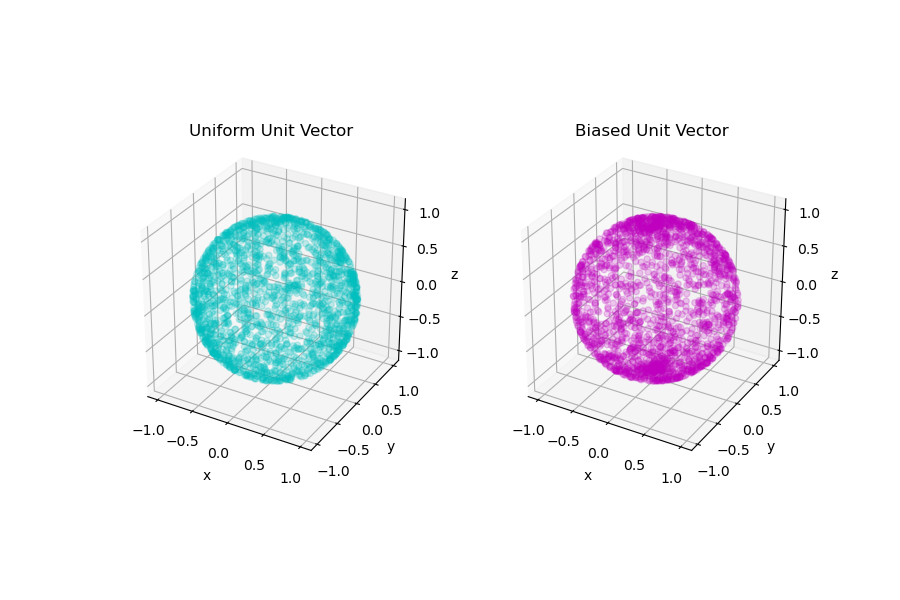

Text(0.5, 0, 'z')

In [13]:
sample_size = 2000

### Creating a sample accounting for theta biasing
r=1  
theta_array = [np.arccos(1-2*(np.random.uniform())) for i in range(sample_size)]
phi_array = [2*np.pi*np.random.uniform() for i in range(sample_size)]

x = r*np.sin(theta_array)*np.cos(phi_array)
y = r*np.sin(theta_array)*np.sin(phi_array)
z = r*np.cos(theta_array)

fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.set_box_aspect((1,1,1))
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.set_box_aspect((1,1,1))

ax1.scatter(x, y, z, color=colours[4], alpha=0.2)
ax1.set_box_aspect([1,1,1])
ax1.set_title("Uniform Unit Vector")
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')

### Creating a biased sampling metho to show the impact of bias
r=1  
theta_array = [np.pi*np.random.uniform() for i in range(sample_size)]
phi_array = [2*np.pi*np.random.uniform() for i in range(sample_size)]

x = r*np.sin(theta_array)*np.cos(phi_array)
y = r*np.sin(theta_array)*np.sin(phi_array)
z = r*np.cos(theta_array)


ax2.scatter(x, y, z, color=colours[5], alpha=0.2)
ax2.set_title("Biased Unit Vector")
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')

## Including Path Length

Now we have a method for creating a uniform random vector, it is just a matter of randomly varying the value of r according to an exponential distribution. 100 random paths are plotted according to the mean free path of absorption of water  to test the method works.

<IPython.core.display.Javascript object>


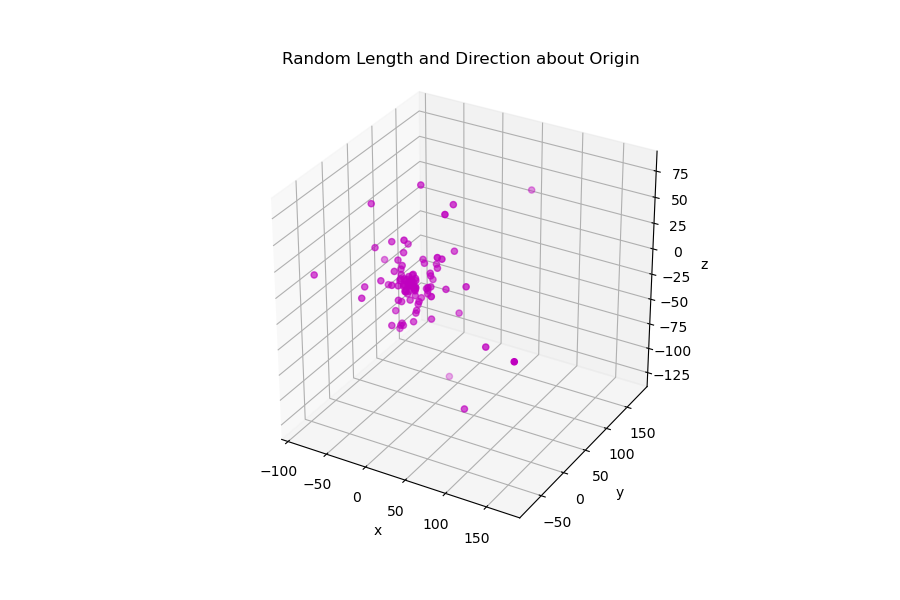

Text(0.5, 0, 'z')

In [14]:
sample_size = 100
mean_free = mean_free_path(density_water, mass_water, absorb_water, 0)

### Ammending the prevous function to also randomly select a path length given a mean free path
r = [exponential_dist(np.random.uniform(), mean_free) for i in range(sample_size)]
theta_array = [np.arccos(1-2*(np.random.uniform())) for i in range(sample_size)]
phi_array = [2*np.pi*np.random.uniform() for i in range(sample_size)]

x = r*np.sin(theta_array)*np.cos(phi_array)
y = r*np.sin(theta_array)*np.sin(phi_array)
z = r*np.cos(theta_array)

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.set_box_aspect((1, 1, 1))
ax.scatter(x, y, z, color=colours[5])
ax.set_title("Random Length and Direction about Origin")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

To speed up the process, functions are defined to give a random path for a neutron given the material it is in. As all neutrons initially have the same direction, another function is also defined to determine how far into the material a given neutron gets before the first interaction.

In [15]:
### Initial position vector, returning the x, y and z coordinates of the first interaction. As all the neutrons enter at the
### same angle perpendicular to the shield, only x changes.
def initial_position(mean_free_path):
    return [0,exponential_dist(np.random.uniform(), mean_free_path)], [0,0], [0,0]

In [16]:
### Uses input angles and path lengths to find the next neutron interaction position
def new_pos(pos, mean_free):
    r = exponential_dist(np.random.uniform(), mean_free)
    theta = np.arccos(1-2*(np.random.uniform()))
    phi = 2*np.pi*np.random.uniform()   
    x = pos[0] + r*np.sin(theta)*np.cos(phi)
    y = pos[1] + r*np.sin(theta)*np.sin(phi)
    z = pos[2] + r*np.cos(theta)
    return x, y, z

In [17]:
### Function determining the probability of a neutron interaction being an absorption or scattering
def interaction_probs(a, b):
    return (a)/(a+b)

# Energy Loss Due to Collision

Neutron scattering interactions will result in a transfer of energy to the shielding material, the amount of which is related to the angle of scattering and the atomic mass. If enough collisions occur, the neutron can be considered absorbed by the shielding material, and is another consideration for a shielding material. 

First of all, the energy distribution needs to be determined. Thermal neutrons are characterised for being about 0.025 eV, so a Maxwell-Boltzmann distribution is used to give each neutron a random energy. $ P(v)= \sqrt{\frac{2}{\pi}}(\frac{m_n}{k_BT})^{\frac{3}{2}} v^2 e^{-\frac{mv^2}{2k_BT}}$ . To randomly sample from this, the scipy.statistics module is used [7], maxwell.pdf().

The scipy function is given by $f(x)=\sqrt{\frac{2}{\pi}}x^2e^{-\frac{x^2}{2}}$, so taking $x^2=\frac{m_nv^2}{k_BT}$ and $k_bT=0.025  eV$ the function can be scaled by $\sqrt{\frac{k_BT}{m_n}}$ to give a Maxwell-Boltzmann distribution about $k_bT$. The distribution is tested below, where both velocity and energy are plotted.

<IPython.core.display.Javascript object>


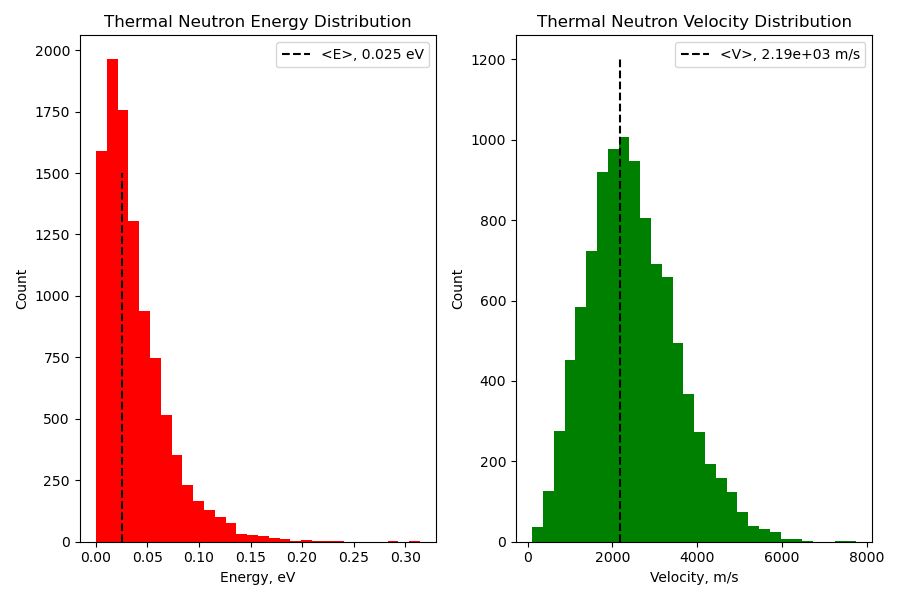

In [18]:
### Scaling the maxwell function and sampling 10,000 points from the distribution. 
maxwell_scalar =  np.sqrt((4.0054414*10**(-21))/(1.67493 * 10**(-27)))
y=[]
for i in range(10000):
    maxwell.pdf(x=0, scale=maxwell_scalar) # equivalent to dividing the function by "scale" - see documentation
    y.append(maxwell.rvs())

### Converting the x variable to energy, and then velocity
E=np.asarray(y)**2*0.025/2
v=np.sqrt((2*E*1.602*10**(-19))/(1.67493 * 10**(-27)))
v_0=np.sqrt((2*0.025*1.602*10**(-19))/(1.67493 * 10**(-27)))

### Creating histograms of energy and velocity
fig,axs = plt.subplots(1,2,figsize=(9,6))

axs[0].hist(E, 30, color=colours[0])
axs[0].plot([0.025, 0.025],[0,1500], "k--")
axs[0].legend(["<E>, 0.025 eV"])
axs[0].set_title("Thermal Neutron Energy Distribution")
axs[0].set_xlabel("Energy, eV")
axs[0].set_ylabel("Count")

axs[1].hist(v, 30, color=colours[1])
axs[1].plot([v_0, v_0],[0,1200], "k--")
axs[1].legend(["<V>, {:.3} m/s".format(v_0)])
axs[1].set_title("Thermal Neutron Velocity Distribution")
axs[1].set_xlabel("Velocity, m/s")
axs[1].set_ylabel("Count")
fig.tight_layout()

Now the energy change needs to be accounted for. The energy change due to a scattering interaction is defined as $E' = \frac{(1+\alpha) +(1-\alpha)cos\theta_c}{2}E$, where $\alpha = \frac{A-1}{A+1}^2$, A being the atomic mass number [8]. Defining a function to calculate each energy change then requires three separate position values, to define the vectors of incidence and scattering to find the angle between the two.

In [19]:
def energy():
    maxwell.pdf(x=0,scale=np.sqrt(0.025/(1.67493 * 10**-25)))
    energy = (maxwell.rvs()**2)*0.025/2 
    return energy

In [20]:
### Function that, given initial energy, mass of the atom hit, and before and after positions of the neutron, calculates the 
### change of energy due to the scattering process
def energy_change(energy, alpha, x, y, z):
    unit_i = [x[1]-x[0], y[1]-y[0], z[1]-z[0]]/np.linalg.norm([x[1]-x[0], y[1]-y[0], z[1]-z[0]]) # Incident unit vector
    unit_s = [x[2]-x[1], y[2]-y[1], z[2]-z[1]]/np.linalg.norm([x[2]-x[1], y[2]-y[1], z[2]-z[1]]) # Scattering unit vector
    angle = np.pi - np.arccos(np.dot(unit_i, unit_s)) # Determining the angle between the unit vectors
    
    return (1/2)*(1+alpha+(1-alpha)*np.cos(angle))*energy

# Simulating Neutron Motion in a Shielding Material

Now we have all the necessary functions defined to simulate the interactions neutrons in a material. The path of a neutron is decided randomly after its entrance in the the shield. It ends due to 1 of 4 outcomes:
1. The neutron passes through the material. Initially, the thickness is set to 10 cm, so if the x position of a neutron is greater than 10, it is considered transmitted.
2. The neutron is reflected. After a series of collisions, the x value of the neutron is less than zero, and will be travelling out of the shield back where it came, and is not considered further.
3. The neutron is absorbed by an atom. The probability of this is defined as P, and each time an interaction occurs a test is made to determine whether absorption occurs, if the random number z is less than P.
4. Loss of energy. If the neutron does not escape after enough collisions, it may lose enough energy to be considered negligible. The test for this is if the energy rounds to zero after the 5th decimal place (measured in eV). This corresponds to a velocity of 31 m/s, 1.5% of the mean velocity of the distribution (2200 m/s)

A test plot is first done, simulating the path of 5 neutrons and displaying each step of the process.

Neutron 1 was reflected back out after 1 collisions, with 0.0126 eV energy.
Neutron 2 was reflected back out after 3 collisions, with 0.0303 eV energy.
Neutron 3 was reflected back out after 3 collisions, with 0.00116 eV energy.
Neutron 4 was reflected back out after 19 collisions, with 0.000414 eV energy.
Neutron 5 was reflected back out after 5 collisions, with 0.0144 eV energy.


<IPython.core.display.Javascript object>


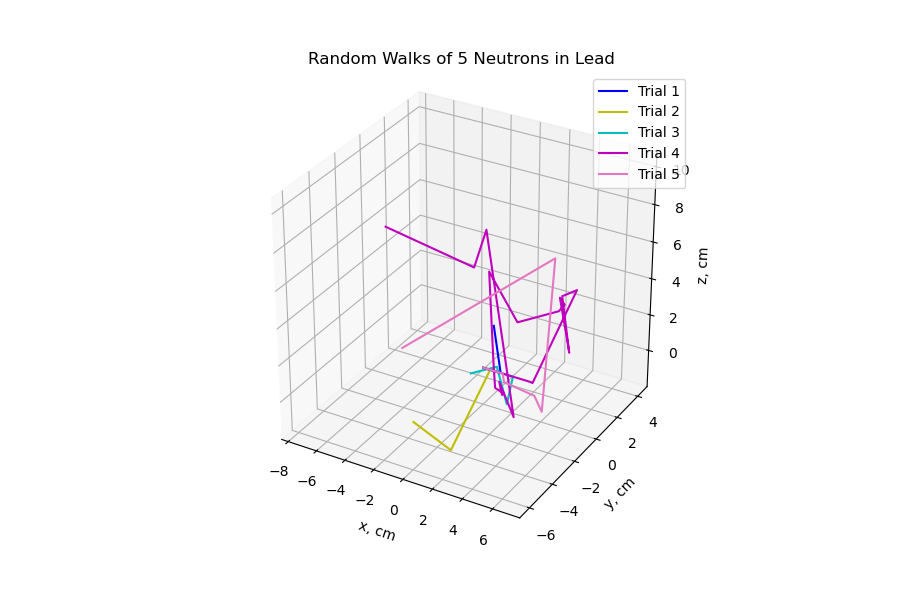

Text(0.5, 0, 'z, cm')

In [21]:
mean_free = mean_free_path(density_lead, mass_lead, absorb_lead, scatter_lead)
p_absorb = interaction_probs(absorb_lead, scatter_lead)
T = 10 #cm, thickness of material
test_particles = 5
pos = [] # Creating a list to contain the position values of each of the simulated particles

for j in range(test_particles):
    is_killed = False
    E = energy()
    x, y, z = initial_position(mean_free)

    while is_killed == False:
        if np.around(E, decimals=5) == 0:
            print("Neutron {} lost all energy.".format(j+1))
            break
        if x[-1] < 0 or x[-1] > T:
            if x[-1] > T:
                print("Neutron {} escaped out the end after {} collisions, with {:.3} eV energy.".format(j+1 ,len(x)-2, E))
            if x[-1] < 0:
                print("Neutron {} was reflected back out after {} collisions, with {:.3} eV energy.".format(j+1 ,len(x)-2, E))
            break
        if np.random.uniform() < p_absorb:
            print("Neutron {} was absorbed after {} collisions, with {:.3} eV energy".format(j+1 ,len(x)-2, E))
            break

        x_s, y_s, z_s = new_pos([x[-1], y[-1], z[-1]], mean_free)
        x.append(x_s)
        y.append(y_s)
        z.append(z_s)
        
        alpha = ((material[1]-1)/(material[1]+1))**2
        E = energy_change(E, alpha, [x[-3], x[-2], x[-1]], [y[-3], y[-2], y[-1]], [z[-3], z[-2], z[-1]])

    pos.append([x, y, z])

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(1,1,1, projection="3d")
ax.set_box_aspect((1, 1, 1))

for i in range(test_particles):
    ax.plot(pos[i][0], pos[i][1], pos[i][2], color=colours[i+2])

ax.legend(["Trial 1","Trial 2","Trial 3","Trial 4","Trial 5"])
ax.set_title("Random Walks of 5 Neutrons in Lead")
ax.set_xlabel("x, cm")
ax.set_ylabel("y, cm")
ax.set_zlabel("z, cm")

Now we have established a method for simulating paths, a it is defined as a function. However, as we know the pathing is working as intended, only the final coordinates need to be saved, as well as the termination reason. This means that there will be less computing load for each run and the process will be faster for larger and repeated sample sizes. 500 neutrons are simulated over 5 runs, passing through 10 cm of lead, water, and graphite, and are plotted below.

In [22]:
### Function simulating the motion of a single neutron, returning the final position, and why the simulation was stopped
def particle_pos(mean_free, T, absorb):
    is_killed = False 
    x, y, z = initial_position(mean_free) 
    E=energy()#eV, the initial energy of the neutron
    
    while is_killed == False:
        if np.around(E, decimals=5) == 0:
            return [x[1],y[1],z[1]], "lost_energy"   
        if x[1]>T or x[1]<0:
            if x[1] > T:
                 return [x[1],y[1],z[1]], "transmit"
            if x[1] < 0:
                return [x[1],y[1],z[1]], "reflect"
        if np.random.uniform() < absorb:
            return [x[1],y[1],z[1]], "absorb"

        ### Calculating the new direction due to collision and the change in energy               
        x_s, y_s, z_s = new_pos([x[1], y[1], z[1]], mean_free)

        alpha = ((material[1]-1)/(material[1]+1))**2
        E = energy_change(E, alpha, [x[0], x[1], x_s], [y[0], y[1], y_s], [z[0], z[1], z_s])

        x = np.array([x[1], x_s])
        y = np.array([y[1], y_s])
        z = np.array([z[1], z_s])

<IPython.core.display.Javascript object>


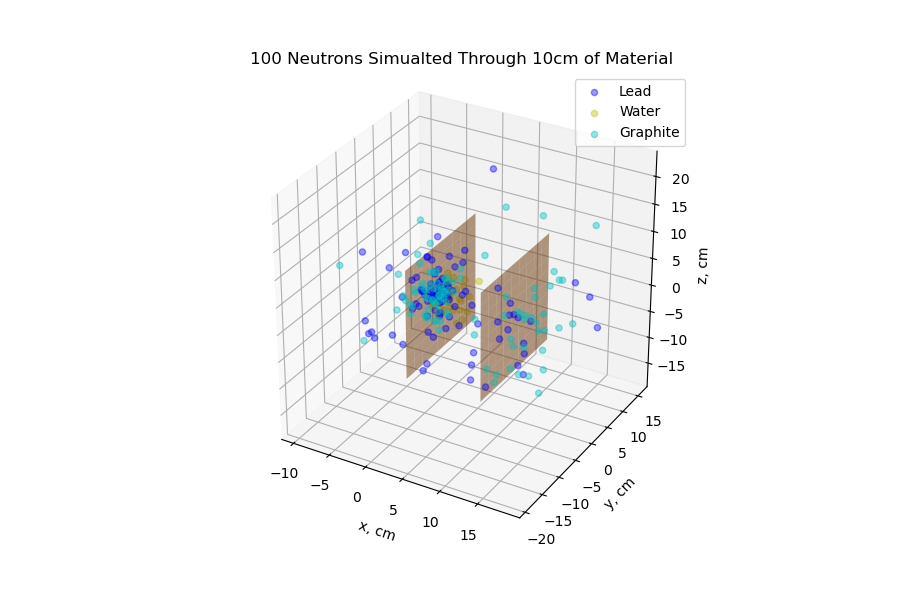

For Lead, 0.16 +- 0.0 were transmitted, 0.13 +- 0.0 were absorbed, 0.71 +- 0.0 were scattered, and 0.0 +- 0.0 lost all energy
For Water, 0.0 +- 0.0 were transmitted, 0.09 +- 0.0 were absorbed, 0.77 +- 0.0 were scattered, and 0.14 +- 0.0 lost all energy
For Graphite, 0.37 +- 0.0 were transmitted, 0.0 +- 0.0 were absorbed, 0.63 +- 0.0 were scattered, and 0.0 +- 0.0 lost all energy


In [23]:
### Setting out how much material is considered, and how many particles will be simulated
T = 10 #cm, thickness of material
test_particles = 100
runs = 1

### Creating a single figure so each of the particles can be compared at the same time.
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(1,1,1, projection="3d")
ax.set_box_aspect((1, 1, 1))

for k, material in enumerate([lead, water, graphite]): 
    mean_free = mean_free_path(material[0], material[1], material[2], material[3])
    p_absorb = interaction_probs(material[2], material[3])
    ### Creating lists to contain the position and end reason arrays for each run:
    ### The propotion of total interactions for each mechanism
    prop_absorb = []
    prop_scatter = []
    prop_transmit = []
    prop_lost_energy = []
    ### Final x,y,z coordinates of each neutron
    matter_array_x = []
    matter_array_y = []
    matter_array_z = []

    for p in range(runs):
        N_Scattered = 0
        N_Transmitted = 0
        N_Absorb = 0
        N_Lost_Energy = 0
        ### Final x,y,z array for a single run
        final_x=[]
        final_y=[]
        final_z=[]    
        ### Simulating the test neutrons
        results = [particle_pos(mean_free, T, p_absorb) for j in range(test_particles)]
        
        ### Analysing the results
        for i in results:
            final_x.append(i[0][0])
            final_y.append(i[0][1])
            final_z.append(i[0][2])
            if i[1] == "reflect":
                N_Scattered += 1
            elif i[1] == "transmit":
                N_Transmitted += 1
            elif i[1] == "absorb":
                N_Absorb += 1
            else:
                N_Lost_Energy += 1
        
        ### Adding the run information to the total
        prop_absorb.append(N_Absorb/test_particles)
        prop_scatter.append(N_Scattered/test_particles)
        prop_transmit.append(N_Transmitted/test_particles)
        prop_lost_energy.append(N_Lost_Energy/test_particles)
        matter_array_x.append(final_x)
        matter_array_y.append(final_y)
        matter_array_z.append(final_z)  
    
    ### Taking the mean and error of each of the mechanisms
    a = np.mean(prop_transmit), np.std(prop_transmit)    
    b = np.mean(prop_absorb), np.std(prop_absorb)
    c = np.mean(prop_scatter), np.std(prop_scatter)
    d = np.mean(prop_lost_energy), np.std(prop_lost_energy)

    print("For {}, {:.4} +- {:.3} were transmitted, {:.4} +- {:.3} were absorbed, {:.4} +- {:.3} \
were scattered, and {:.4} +- {:.3} lost all energy".format(names[k], a[0], a[1], b[0], b[1], c[0], c[1], d[0], d[1]))
    ax.scatter(matter_array_x, matter_array_y, matter_array_z, alpha = 0.4, color=colours[k+2])

ax.set_title("{} Neutrons Simualted Through {}cm of Material".format(runs*test_particles, T))
ax.set_xlabel("x, cm")
ax.set_ylabel("y, cm")
ax.set_zlabel("z, cm")
   

m = np.linspace(-10,10,10)
n = np.linspace(-10,10,10)
Y,Z = np.meshgrid(m,n) 
ax.plot_surface(0,Y, Z, alpha=0.5, color=colours[9])
ax.plot_surface(T,Y, Z, alpha=0.5, color=colours[9])
ax.legend(["Lead","Water", "Graphite"])

While this is a small sample, this gives a cursory idea of how each of these materials will interact with the neutrons, and shows us that the position function is behaving as expected. However, a much larger sample size is required to find a definitive value for the attenuation. Increasing the sample size by 10-100 times will drastically increase the computing time, so the final positions will no longer be recorded after the path is simulated, and the result will be only be tallied.

Now, 1000 neutrons will be simulated passing through each of the materials for 5 runs to find the proportion of neutrons being transmitted, absorbed, reflected or losing all energy, and the approximate associated error.

In [24]:
### Redefining the previous function without including a return on final position, as a plot is not being made
def particle_sim(mean_free, T, absorb):
    is_killed = False 
    x, y, z = initial_position(mean_free) 
    E=energy() #eV, the initial energy of the neutron
    
    while is_killed == False:
        if np.around(E, decimals=5) == 0:
            return "lost_energy"               
        if x[1]>T or x[1]<0:
            if x[1] > T:
                return "transmit"
            if x[1] < 0:
                return "reflect"
        if np.random.uniform() < absorb:
            return "absorb"
        
        ### Calculating the new direction due to collision and the change in energy
        x_s, y_s, z_s = new_pos([x[1], y[1], z[1]], mean_free)

        alpha = ((material[1]-1)/(material[1]+1))**2
        E = energy_change(E, alpha, [x[0], x[1], x_s], [y[0], y[1], y_s], [z[0], z[1], z_s])

        x = np.array([x[1], x_s])
        y = np.array([y[1], y_s])
        z = np.array([z[1], z_s])

In [25]:
### Setting how much material is considered, and how many particles will be simulated
T = 10 #cm, thickness of material
test_particles = 1000
runs = 5

for k, material in enumerate(matter): 
    mean_free = mean_free_path(material[0], material[1], material[2], material[3])
    p_absorb = interaction_probs(material[2], material[3])  
    ### Creating lists to contain the position and end reason arrays for each run:
    ### The propotion of total interactions for each mechanism
    prop_absorb = []
    prop_scattered = []
    prop_transmit = []
    prop_lost_energy = [] 
    
    for p in range(runs):  
        ### Resetting the tallies for the run
        N_Scattered = 0
        N_Transmitted = 0
        N_Absorb = 0
        N_Lost_Energy = 0
        
        results = [particle_sim(mean_free, T, p_absorb) for j in range(test_particles)]

        for i in results:
            if i == "reflect":
                N_Scattered += 1
            elif i == "transmit":
                N_Transmitted += 1
            elif i == "absorb":
                N_Absorb += 1
            else:
                N_Lost_Energy += 1
                
        prop_absorb.append(N_Absorb/test_particles)
        prop_scattered.append(N_Scattered/test_particles)
        prop_transmit.append(N_Transmitted/test_particles)
        prop_lost_energy.append(N_Lost_Energy/test_particles)

    absorbed = np.mean(prop_absorb), np.std(prop_absorb)
    scattered = np.mean(prop_scattered), np.std(prop_scattered)
    transmitted = np.mean(prop_transmit), np.std(prop_transmit)
    lost_energy = np.mean(prop_lost_energy), np.std(prop_lost_energy)
    
    print("For {}, {:.4} +- {:.3} were transmitted, {:.3} +- {:.2} were absorbed, {:.3} +- {:.2} \
were scattered, and {:.4} +- {:.3} lost all energy.".format(names[k], transmitted[0], transmitted[1], absorbed[0],
                                                               absorbed[1], scattered[0], scattered[1], lost_energy[0],
                                                               lost_energy[1]))

For Lead, 0.2708 +- 0.0211 were transmitted, 0.105 +- 0.008 were absorbed, 0.624 +- 0.017 were scattered, and 0.0 +- 0.0 lost all energy.
For Water, 0.0 +- 0.0 were transmitted, 0.134 +- 0.0083 were absorbed, 0.756 +- 0.0098 were scattered, and 0.1102 +- 0.00564 lost all energy.
For Graphite, 0.309 +- 0.00888 were transmitted, 0.0074 +- 0.0036 were absorbed, 0.679 +- 0.013 were scattered, and 0.0042 +- 0.00194 lost all energy.


These results indicate that for thermal neutron radiation, water is the most effective of the three, transmitting a negligible amount of neutrons. Lead and graphite are comparable, however, graphite appears slightly more effective. This is likely because, while it does not absorb so many neutrons, lead is better at scattering neutrons, and the lower atomic mass means more energy is transferred from the neutron per collision.

Before making final calculations, the number of test particles to be used needs to be established, as well as the number of runs. A range are plotted below to establish how in particular the error will change. One would expect diminishing returns similar to the change with increasing the number of runs, and the optimal size would be when there is no appreciable difference in doubling the size. Error from repeated readings is $\sigma\propto\frac{1}{\sqrt{n}}$, r being the number of runs, and will be determined subsequently. For this first test, 10 runs are taken to reduce the impact of run variation in the error.

<IPython.core.display.Javascript object>


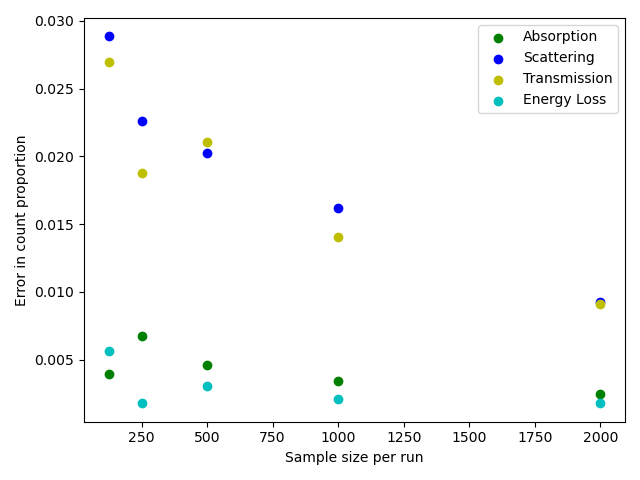

In [51]:
### Setting how much material is considered, and how many particles will be simulated
T = 10 #cm, thickness of material
test_range = ([125, 250, 500, 1000, 2000])
runs = 10

mean_free = mean_free_path(graphite[0], graphite[1], graphite[2], graphite[3])
p_absorb = interaction_probs(graphite[2], graphite[3])  

absorbed = []
scattered = []
transmitted = []
lost_energy = []

for p in test_range:
    ### Creating lists to contain the position and end reason arrays for each run:
    ### The propotion of total interactions for each mechanism
    prop_absorb = []
    prop_scattered = []
    prop_transmit = []
    prop_lost_energy = [] 

    for i in range(runs):  
        ### Resetting the tallies for the run
        N_Scattered = 0
        N_Transmitted = 0
        N_Absorb = 0
        N_Lost_Energy = 0
        results = [particle_sim(mean_free, T, p_absorb) for j in range(p)]

        for i in results:
            if i == "reflect":
                N_Scattered += 1
            elif i == "transmit":
                N_Transmitted += 1
            elif i == "absorb":
                N_Absorb += 1
            else:
                N_Lost_Energy += 1
        prop_absorb.append(N_Absorb/p)
        prop_scattered.append(N_Scattered/p)
        prop_transmit.append(N_Transmitted/p)
        prop_lost_energy.append(N_Lost_Energy/p)

    absorbed.append(np.std(prop_absorb))
    scattered.append(np.std(prop_scattered))
    transmitted.append(np.std(prop_transmit))
    lost_energy.append(np.std(prop_lost_energy))

fig, ax = plt.subplots(1,1)
ax.scatter(test_range, absorbed, color=colours[1]) 
ax.scatter(test_range, scattered, color=colours[2])
ax.scatter(test_range, transmitted, color=colours[3]) 
ax.scatter(test_range, lost_energy, color=colours[4]) 
ax.set_xlabel("Sample size per run")
ax.set_ylabel("Error in count proportion")
ax.legend(["Absorption", "Scattering", "Transmission", "Energy Loss"])
fig.tight_layout()

The results of this plot agree with the expectation of diminishing returns with increasing n. Above 1000 simulations the change in error appears negligible, so it appears a decrease in computational time compared to 2000 simulations is worth the small accuracy penalty. Now this is fixed, the run range will be tested for 4 different values, 5, 8, 10, and 12, to determine the impact on error.

<IPython.core.display.Javascript object>


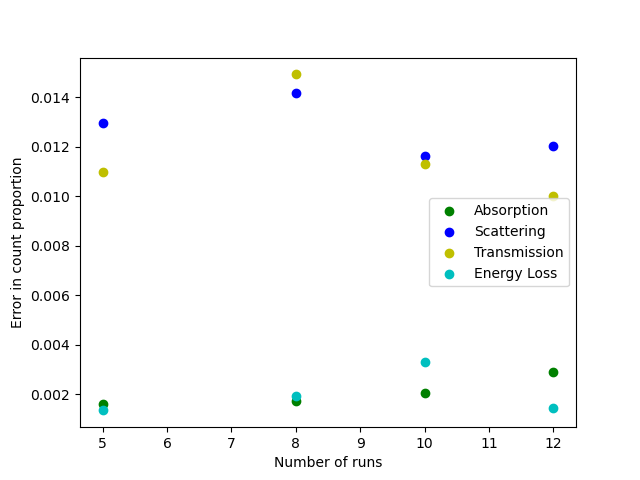

In [52]:
### Setting how much material is considered, and how many particles will be simulated
T = 10 #cm, thickness of material
test_particles = 1000
run_range = ([5, 8, 10, 12])

mean_free = mean_free_path(graphite[0], graphite[1], graphite[2], graphite[3])
p_absorb = interaction_probs(graphite[2], graphite[3])  

absorbed = []
scattered = []
transmitted = []
lost_energy = []

for p in run_range:
    ### Creating lists to contain the position and end reason arrays for each run:
    ### The propotion of total interactions for each mechanism
    prop_absorb = []
    prop_scattered = []
    prop_transmit = []
    prop_lost_energy = [] 

    for i in range(p):  
        ### Resetting the tallies for the run
        N_Scattered = 0
        N_Transmitted = 0
        N_Absorb = 0
        N_Lost_Energy = 0
        results = [particle_sim(mean_free, T, p_absorb) for j in range(test_particles)]

        for i in results:
            if i == "reflect":
                N_Scattered += 1
            elif i == "transmit":
                N_Transmitted += 1
            elif i == "absorb":
                N_Absorb += 1
            else:
                N_Lost_Energy += 1
        prop_absorb.append(N_Absorb/test_particles)
        prop_scattered.append(N_Scattered/test_particles)
        prop_transmit.append(N_Transmitted/test_particles)
        prop_lost_energy.append(N_Lost_Energy/test_particles)

    absorbed.append(np.std(prop_absorb))
    scattered.append(np.std(prop_scattered))
    transmitted.append(np.std(prop_transmit))
    lost_energy.append(np.std(prop_lost_energy))

fig, ax = plt.subplots(1,1)
ax.scatter(run_range, absorbed, color=colours[1]) 
ax.scatter(run_range, scattered, color=colours[2])
ax.scatter(run_range, transmitted, color=colours[3]) 
ax.scatter(run_range, lost_energy, color=colours[4]) 
ax.set_xlabel("Number of runs")
ax.set_ylabel("Error in count proportion")
ax.legend(["Absorption", "Scattering", "Transmission", "Energy Loss"])

The results of run variation are far less definitive than increasing the sample size. While there is a slight improvement at 12 runs, it appears that sample size is far more impactful on the error than number of runs, as fluctuations appear to have a significant impact at a fixed sample. As a result, 5 runs will be used for the subsequent calculations, as for the precision to be noticably increased the computational time would most likely be 5 or more times greater.

# Determining Attenuation Distance

To make a quantitative comparison of each of these materials, the attenuation distance needs to be determined. This will follow a similar methodology to before, but some changes will needed to be made to account for scattering. This is done by counting how many neutrons are transmitted for a series of increasing material thicknesses. After doing this, the natural log can be taken of the counts like before, and the negative inverse of the gradient will give the attenuation distance.

As an aside, the length of time on computing these results indicates that the attenuation calculation, around 150,000 neutrons simulated, will be very demanding. The large computing time is likely due to the energy calculations, which are intensive & contain a significant amount of data compared to the other calculations. While the energy consideration accounts for around 10% of all water neutrons, it is completely negligible in the case of lead and only around 0.3% in graphite. To speed up the computation, energy is not considered further in the following function, but the results of a calculation considering energy are included in an image below.

In [28]:
### Updating the initial position function as the origin is not required for any calculations if energy is not considered
def initial_position_no_start(mean_free_path):
    return exponential_dist(np.random.uniform(), mean_free_path), 0, 0

In [29]:
def particle_sim_no_energy(mean_free, T, absorb):
    is_killed = False 
    x, y, z = initial_position_no_start(mean_free) 
    
    while is_killed == False:
        if x>T or x<0:
            if x > T:
                 return "transmit"
            if x < 0:
                return "reflect" 
        if np.random.uniform() < absorb:
            return "absorb"
        ### Only calculating the new position          
        x, y, z = new_pos([x, y, z], mean_free)

To find the attenuation distances and associated error for each material, 1000 neutrons will be simulated for 10 different thicknesses of each material. Repeating this 5 times, the mean attenuation distance is calculated, as well as the associated error.

<IPython.core.display.Javascript object>


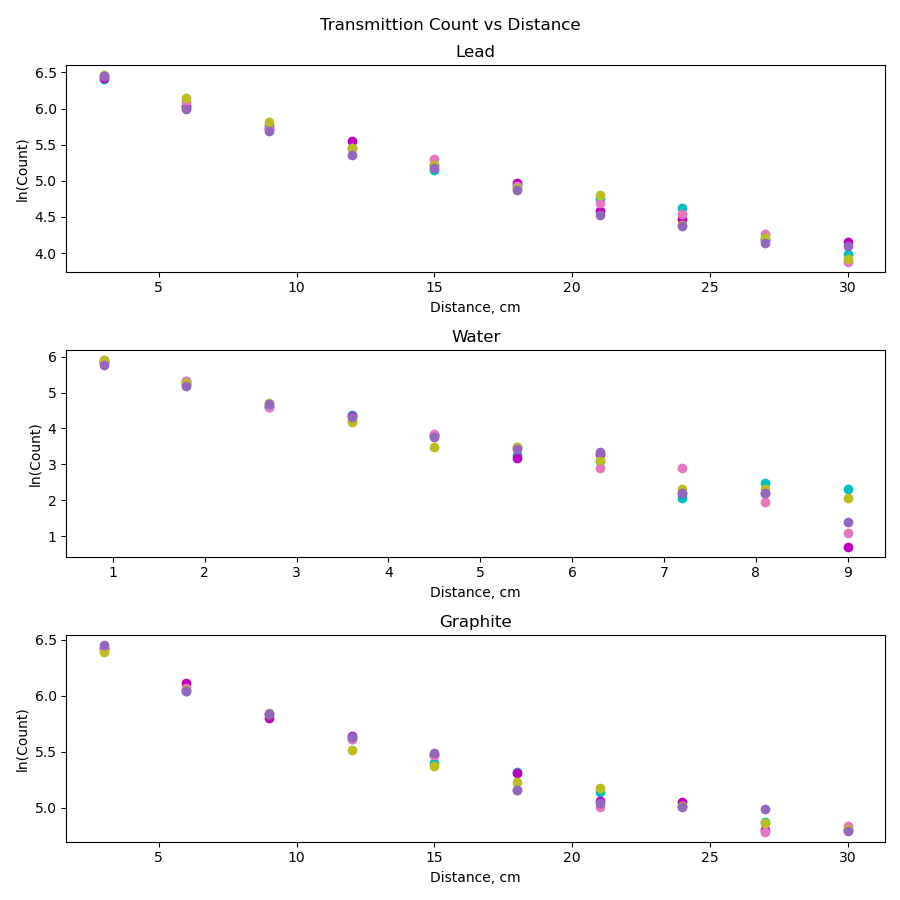

For Lead, the attenuation distance is 11.3 +- 0.312
For Water, the attenuation distance is 1.97 +- 0.143
For Graphite, the attenuation distance is 17.2 +- 0.372
These values were determined  by taking the mean of 5 runs of 1000 neutrons, for 10 thicknesses.


In [30]:
### The base functions have been optimized, not cacheing prior positons and by not considering energy. 
### The bottleneck appears to be the "for" loops, which are known to be very inefficient compared to functions such as 
### np.where(). However, np.where() does not recall the function to be returned after each comparison (np.where() 
### gives a return based on a true-false condition), so the 1st generated random number would be used for each neutron 
### simuation. As a result, a comprehensive but simplified function is run here with "for" loops, and a screenshot of a more 
### complete, longer run is included later, which accounted for energy and included more runs.

### Setting up the runs and bin range, range is set to be 11, but only 10 are used as T=0 is not considered
range_T = 11
T_values = ([np.linspace(0,30,range_T), np.linspace(0,9,range_T), np.linspace(0,30,range_T)])
test_particles = 1000
runs = 5

prop_absorb = []
prop_scatter = []
prop_transmit = []
prop_loss = []

matter_array_x = []
matter_array_y = []
matter_array_z = []

fig,axs = plt.subplots(3,1)
fig.set_size_inches(9,9)
fig.suptitle("Transmittion Count vs Distance")

for k, material in enumerate(matter): 
    mean_free = mean_free_path(material[0], material[1], material[2], material[3])
    p_absorb = interaction_probs(material[2], material[3])   
    attenuation = []   
    T_array = T_values[k]
    
    for p in range(runs):
        transmission_array = []
        
        for T in T_array[1:]:
            N_Transmitted = 0

            results = [particle_sim_no_energy(mean_free, T, p_absorb) for j in range(test_particles)]

            for i in results:
                if i == "transmit":
                    N_Transmitted += 1

            transmission_array.append(N_Transmitted)
        
        o = []
        f = []
        g = []
        
        for i, value in enumerate(transmission_array):
            if value != 0:
                o.append(T_array[i+1])
                f.append(np.log(value))
                g.append(value)
        coef = np.polyfit(o,f,1)
        attenuation.append(-1/coef[0])
        
        
        axs[k].scatter(o, f,color=colours[p+4])

        axs[k].set_title(names[k])
        axs[k].set_xlabel("Distance, cm")
        axs[k].set_ylabel("ln(Count)")
    print("For {}, the attenuation distance is {:.3} +- {:.3}".format(names[k], np.mean(attenuation),np.std(attenuation),"cm"))
print("These values were determined  by taking the mean of {} runs of {} neutrons, for {} thicknesses."\
      .format(runs, test_particles,range_T-1))
fig.tight_layout()

The results of this simulation show that the attenuation distance of thermal neutrons in water is around 1.8 cm, which reflects the results seen in previous simulations. Lead is considerably worse than water, with a path of around 11cm, and the worst is graphite with a path of around 17 cm. However, it was established previously that there is a systematic over estimation that, while minimized with the bin size choice, will still affect the results. Also, by not considering energy loss there will be a further over estimation in the value. Nevertheless, this result is in agreement with similar Monte-Carlo simulations such as those done by Shahmohammadi et al [9], who found it to be around 0.7 cm (the work mostly concentrated around the MeV range, but thermal energies are also included). The results show that both lead and graphite are around 10 times less effective than water at attenuating neutron radiation, but lead is a better option, especially when considering a nuclear reactor where gamma radiation is also likely to be present. 

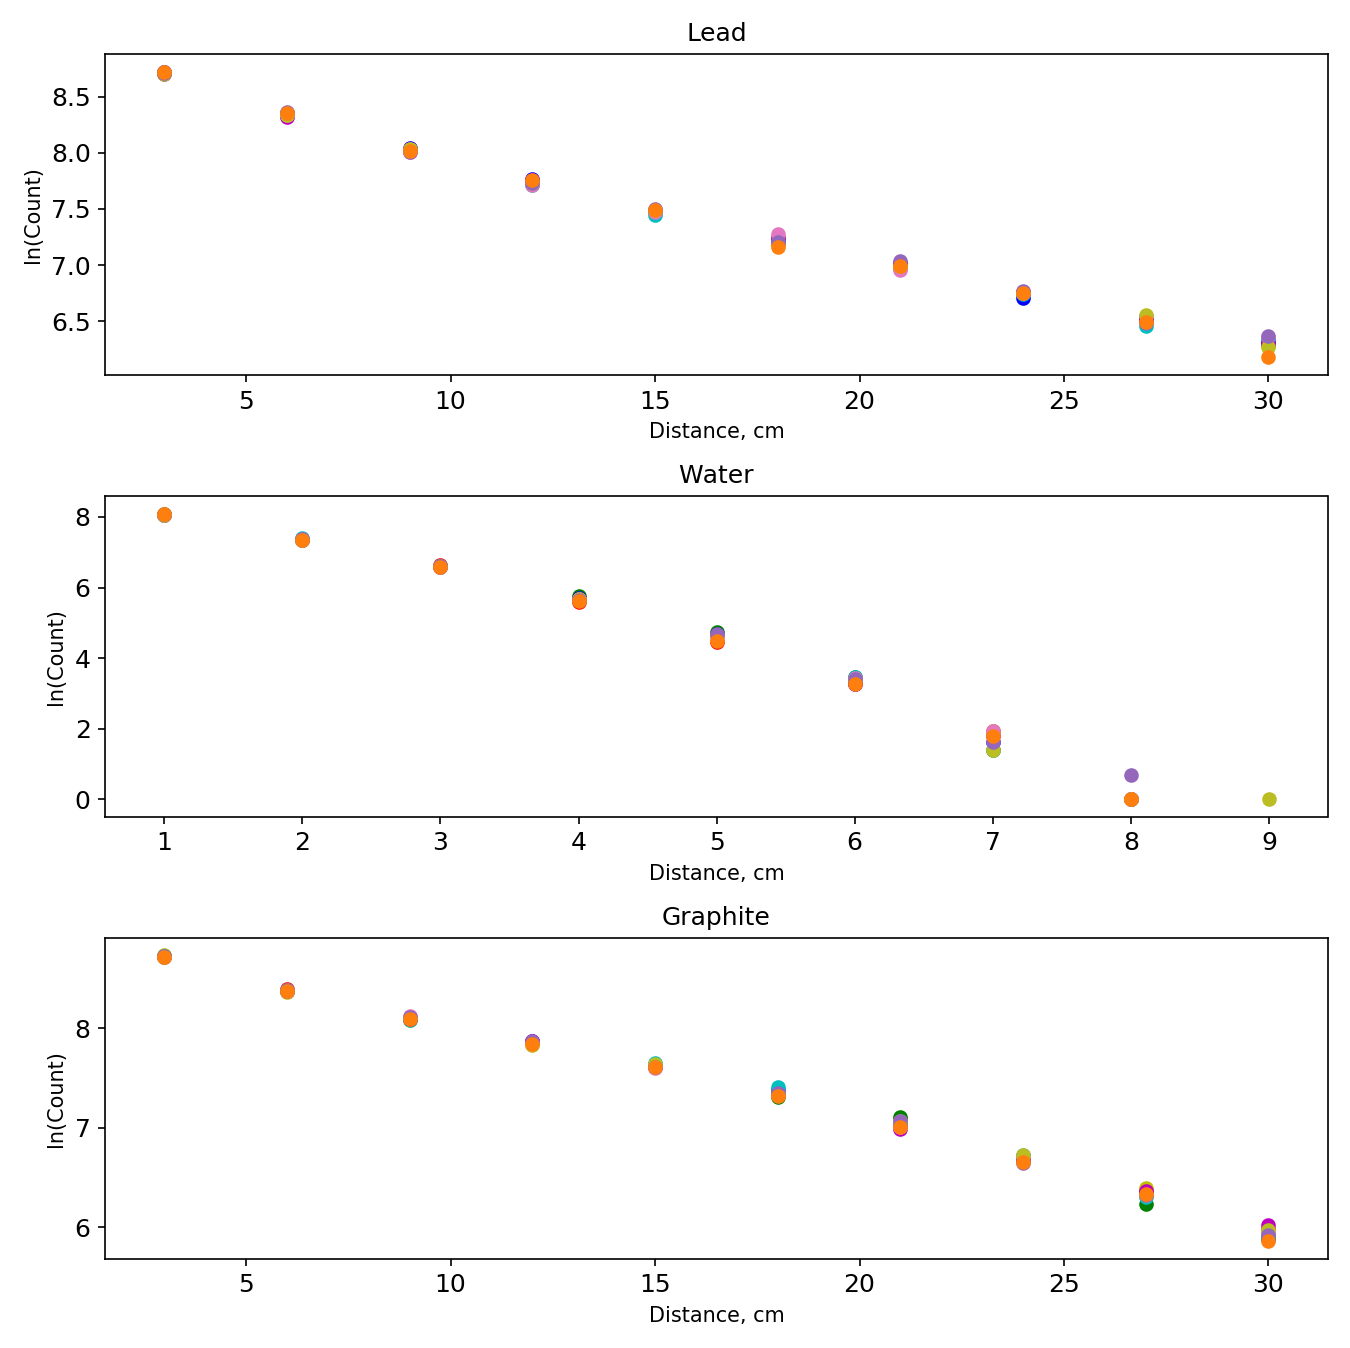

In [31]:
display.Image("https://i.imgur.com/z4KIws5.png")

The data here is taken from 10,000 neutron simulations run 10 times for 10 different thickness. These calculations, including a consideration of energy, gave an attenuation length of 11.4 $\pm$ 0.2 cm for lead, 0.903 $\pm$ 0.036 for water, and 10.1 $\pm$ 0.1 for graphite.

While the results for a lead and water are relatively consistent, the graphite result is drastically different when energy is accounted for. This is likely because for lead, the atomic mass means very little energy is lost between collisions, and in the case of water, neutrons did not spend enough time in the material to lose energy before escaping. Graphite is less massive than lead but otherwise behaved similarly to lead, so we would expect that more neutrons would lose energy. The magnitude of this indicates that graphite may in fact be slightly more effective at attenuating thermal neutrons.

It is important to note that the energy cut-off was an arbitrary point where the velocity is approximately 1% of the average. This assumption implies that neutrons of this energy are negligible and will not be a hazard, as that is the point radiation shielding, but this may not be reflected in the real behaviour of neutrons at this energy. If this assumption were not the case, graphite would not be as effective at shielding as would be implied by these results.

## Choosing a Shield

These results show that water is the best option for thermal neutron shielding, as the mean free path, both considering and discarding energy calculations, was significantly shorter than either lead or graphite. However, lead and graphite may be of more interest if a shield was required to shield against other radiation sources as well as neutrons, as both materials had path lengths of 10cm, which is still relatively small.

An aspect to be investigated further may be the threshold for discounting an a neutron based on energy, as considering 1% velocity to be the threshold gave graphite a substantial improvement in path length. Also to consider is the effect of multiple layers of material between the source and transmission. Standard Monte Carlo methods could deal with this problem, however many calculations would need to be made to correct path length if the material boundary is crossed, so an alternative method of simulation may be required.

# The Woodcock Method 

The work up to now has assumed the mean free path of the neutrons, until incident with the material, was infinite and not considered. However, when two materials are interfaced, a model cannot make such an assumption. The Woodcock method offers a solution far more efficient than solving the geometric problems the method followed up until now would require.

For this section, a germanium-aluminium interface will be considered, and the absorption and scattering cross-sections were found from NIST [4].

In [32]:
### Using values found from NIST
density_aluminium = 2.6989 # g/cm^3
density_germanium = 5.323 # g/cm^3

mass_aluminium = 26.981539 # amu
mass_germanium = 72.64 # amu

absorb_aluminium = 0.231 # barn, 10^-28 m^2
absorb_germanium = 2.2 # barn

scatter_aluminium = 1.503 # barn
scatter_germanium = 8.6 # barn

aluminium = ([density_aluminium, mass_aluminium, absorb_aluminium, scatter_aluminium])
germanium = ([density_germanium, mass_germanium, absorb_germanium, scatter_germanium])
vacuum_approx = ([density_aluminium, mass_aluminium, 0.00001, 0.00001])

For the Woodcock method, fictional steps of the shorter mean free path are taken when in the other, longer path, region. In a fictional step, no scattering or absorption occurs, and direction between fictional steps does not change. At the end of each fictional step, a check is made to test if the next will be real or not, as then interactions will need to be accounted for. At this time, position tests are also run to see if the neutron has moved to the other region or left the system entirely. 
When the neutron is in the shorter mean free path region, it will behave like in the prior Monte Carlo simulations.

First, some functions need to be defined. In particular, a random unit vector generator, as only direction is needed, and a test to see if a step is fictitious or real.

In [33]:
### Function to find the mean free path of a neutron considering only scattering and absorption. The molecular mass is assumed
### to be inputted in amu, and microscopic cross sections in barns. The density is assumed to be in g/cm^3.
def path(material):
    amu = 1.6605 * 10 ** (-24) # g
    barn = 10 ** (-24) # cm^2
    n = material[0]/ (material[1] * amu) # cm^-3
    return 1/(n*material[2]*barn + n*material[3]*barn) 

In [34]:
### Generates a unit vector in a random direction
def random_unit_vector():
    theta = np.arccos(1-2*(np.random.uniform()))
    phi = 2*np.pi*np.random.uniform()
    return theta, phi

In [35]:
### Returns a random path length sampled from the mean free path distribution of pt
def path_length(pt):
    u = np.random.uniform()
    return -(pt)*np.log(u)

In [36]:
### Compares a random number to the threshold fictitiousness. Returning a number more than the threshold will mean the step is 
### considered fictitious
def fictitious_test(p, pt):
    u = np.random.uniform()
    if u < 1-pt/p: return "fic"
    else: return "real"

In [37]:
### Returns whether a neutron is absorbed or scattered
def absorption_test(absorb, scatter):
    u = np.random.uniform()  
    if u < (absorb)/(absorb + scatter): return "absorb"
    return

## Defining the Movement of a Neutron

Here, functions for the motion of a single neutron are defined. The step function makes a series of fictitious steps in a random direction, until a steps become real. The first step function also runs until a  step becomes real, however it  begins by assuming the direction to be in the x direction, normal to the interface. The simulation function uses both these functions and, given the set up of the system and an initial position, will simulate the motion of a neutron and return the path and reason for ending.

In [38]:
### Given initial coordinates, the function makes a total real step in the x direction, so that simulations are initially
### uniform in direction.
def first_step(pos_i, p1, pt, b, l):
    is_killed = False
    x = pos_i[0]
    y = pos_i[1]
    z = pos_i[2]
        
    real = False
    while real == False:
        r = path_length(pt)
        x.append(x[-1] + r)
        y.append(0)
        z.append(0)
        if fictitious_test(p1, pt) == "real" or x[-1]<0 or x[-1]>b: real = True
    return x,y,z

In [39]:
### Given initial position, a series of steps will be taken in a randomly chosen direction, until a real step occurs,
### the neutron enters the other region or leaves entirely. The function assumes the section between the origin and boundary is
### the region with higher mean free path. In the lower path region the function only takes one step.
def step_function(pos, p1, pt, b, l):
    is_killed = False
    x = pos[0]
    y = pos[1]
    z = pos[2]
    theta, phi = random_unit_vector()    
    real = False
    while real == False:
        r = path_length(pt)
        x.append(x[-1] + r*np.sin(theta)*np.cos(phi))
        y.append(y[-1] + r*np.sin(theta)*np.sin(phi))
        z.append(z[-1] + r*np.cos(theta))
        if fictitious_test(p1, pt) == "real" or x[-1]<0 or x[-1]>b:
            return x,y,z

In [40]:
### Model simulating the path of neutron at an interface of two materials of variable thicknesses, returning all position data
def neutron_sim(x, y, z, b, l, mat1, mat2):
    is_killed = False
    path_1 = path(mat1)
    path_t = path(mat2)
    
    x, y, z = first_step([x,y,z], path_1, path_t, b, l)
    
    while is_killed == False:
        if x[-1]<0:
            return x, y, z, "scatter"

        elif x[-1]>l:
            return x, y, z, "transmit"
        
        elif b<x[-1]<l:

            absorb = absorption_test(mat2[2], mat2[3])
            if absorb == "absorb":
                return x, y, z, "absorb2"

        elif 0<x[-1]<b:
            absorb = absorption_test(mat1[2], mat1[3])
            if absorb == "absorb":
                return x, y, z, "absorb1"
        x, y, z= step_function([x, y, z], path_1, path_t, b, l)    

# Testing the Woodcock Method

Now the functions are defined, the walks of 5 neutrons will be simulated and plotted at the aluminium-germanium interface. However, before applying this model to situations we need to establish it is representative of the real world. Therefore, an approximation will be made to the first region, reducing the cross-sectional absorption and scattering values to approximate a vacuum by drastically increasing the mean free path. As a qualitative assessment, we would expect paths in region 1 to not change direction before reaching the germanium, and neutrons backscattered into the vacuum would only follow straight paths.

<IPython.core.display.Javascript object>


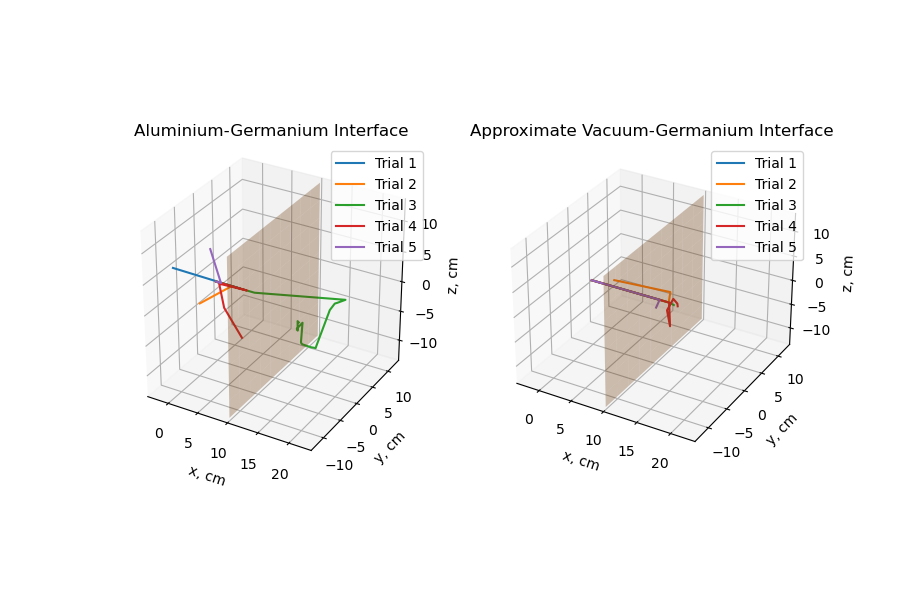

Neutron 1 was scattered.
Neutron 2 was scattered.
Neutron 3 was absorbed in material 2.
Neutron 4 was absorbed in material 2.
Neutron 5 was scattered.
The mean free path of the vacuum approximation is 8.3e+05 cm
Neutron 1 was absorbed in material 2.
Neutron 2 was scattered.
Neutron 3 was absorbed in material 2.
Neutron 4 was absorbed in material 2.
Neutron 5 was absorbed in material 2.


In [41]:
path_1 = path(aluminium)
path_2 = path(germanium)
path_t = np.amin([path_1, path_2]) # Finding the smaller path length

l = 20 # cm, length of test box (x axis)
b = 10 # cm, boundary along the test box from subsstance 1 to 2
test_particles = 5

m = np.linspace(-3-l/2,3+l/2,10)
n = np.linspace(-3-l/2,3+l/2,10)
M,N = np.meshgrid(m,n)
O = b       
fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(1,2,1, projection="3d")
ax1.set_box_aspect((1, 1, 1))


for i in range(test_particles):
    x, y, z, reason = neutron_sim([0], [0], [0], b, l, aluminium, germanium)
    ax1.plot(x, y, z)   
    
    if reason =="scatter":
        print("Neutron {} was scattered.".format(i+1))
        
    elif reason=="transmit":
        print("Neutron {} was transmitted.".format(i+1))
 
    elif reason=="absorb2":
        print("Neutron {} was absorbed in material 2.".format(i+1))
        
    else: print("Neutron {} was absorbed in material 1.".format(i+1))

ax1.set_title("Aluminium-Germanium Interface")        
ax1.set_xlabel("x, cm")
ax1.set_ylabel("y, cm")
ax1.set_zlabel("z, cm")
ax1.set_xlim(-3,l+3)
ax1.set_ylim(-3-l/2,3+l/2)
ax1.set_zlim(-3-l/2,3+l/2)
ax1.legend(["Trial 1", "Trial 2", "Trial 3", "Trial 4" , "Trial 5"])
ax1.plot_surface(O,M, N, alpha=0.3, color=colours[9])

print("The mean free path of the vacuum approximation is {:.3} cm".format(path(vacuum_approx)))
ax2 = fig.add_subplot(1,2,2, projection="3d")
ax1.set_box_aspect((1, 1, 1))

for i in range(test_particles):
    x, y, z, reason = neutron_sim([0], [0], [0], b, l, vacuum_approx, germanium)
    ax2.plot(x, y, z)   
    
    if reason =="scatter":
        print("Neutron {} was scattered.".format(i+1))
        
    elif reason=="transmit":
        print("Neutron {} was transmitted.".format(i+1))
 
    elif reason=="absorb2":
        print("Neutron {} was absorbed in material 2.".format(i+1))
        
    else: print("Neutron {} was absorbed in material 1.".format(i+1))

ax2.set_title("Approximate Vacuum-Germanium Interface")
ax2.set_xlabel("x, cm")
ax2.set_ylabel("y, cm")
ax2.set_zlabel("z, cm")
ax2.set_xlim(-3,l+3)
ax2.set_ylim(-3-l/2,3+l/2)
ax2.set_zlim(-3-l/2,3+l/2)
ax2.legend(["Trial 1", "Trial 2", "Trial 3", "Trial 4" , "Trial 5"])
ax2.plot_surface(O,M, N, alpha=0.3, color=colours[9])

The paths in each plot agree with the expectation, so a more rigorous assessment will be made. First, the functions are updated to only store the current neutron position so more neutrons can be processed more quickly. The Monte Carlo particle position function is also updated to not consider energy.

## Comparison With Monte Carlo Methods

The Woodcock technique will now compared to the Monte Carlo method for both sides of the boundary. Firstly, germanium is interfaced with the approximate vacuum, with the boundary at 0 and a thickness of 10 cm. The transmission results are tallied and compared with the results of a Monte Carlo simulation, which we would expect to be in agreement.

In the aluminium case, it is interfaced with a block of germanium where the boundary and block length are equal, making it a pure aluminium block undergoing the Woodcock method with germanium. The transmission results are again tallied and compared with a similar Monte Carlo simulation.

If, for both sides of the barrier, the results are consistent with the Monte Carlo method, the function is working and the results of the Woodcock method are reliable.

In [54]:
def first_woodcock(pos_i, p1, pt, b, l):
    is_killed = False
    x = pos_i[0]
    y = pos_i[1]
    z = pos_i[2]

    real = False
    while real == False:
        r = path_length(pt)
        x= x + r
        if fictitious_test(p1, pt) == "real" or x<0 or x>b:
            return x,y,z

In [55]:
def step_woodcock(pos, p1, pt, b, l):
    is_killed = False
    x = pos[0]
    y = pos[1]
    z = pos[2]
    theta, phi = random_unit_vector()
    
    real = False
    while real == False:
        r = path_length(pt)
        x = x + r*np.sin(theta)*np.cos(phi)
        y = y + r*np.sin(theta)*np.sin(phi)
        z = z + r*np.cos(theta)
        if fictitious_test(p1, pt) == "real" or x<0 or x>b:
            return x,y,z

In [56]:
def neutron_woodcock(x, y, z, b, l, mat1, mat2):
    is_killed = False

    path_1 = path(mat1)
    path_t = path(mat2)
    x, y, z = first_woodcock([x,y,z], path_1, path_t, b, l) 
    
    while is_killed == False:
        if x<0:
            return x, y, z, "scatter"
        elif b<x<l: 
            absorb = absorption_test(mat2[2], mat2[3]) 
            if absorb == "absorb":
                return x, y, z, "absorb2"
        elif 0<x<b:
            absorb = absorption_test(mat1[2], mat1[3]) 
            if absorb == "absorb":
                return x, y, z, "absorb1"
        elif x>l:
            return x, y, z, "transmit"
        x, y, z= step_woodcock([x, y, z], path_1, path_t, b, l)   

In [45]:
### Model simulating the path of neutron at an interface of two materials of variable thicknesses, returning all position data
def neutron_sim(x, y, z, b, l, mat1, mat2):
    is_killed = False
    path_1 = path(mat1)
    path_t = path(mat2)
    
    x, y, z = first_step([x,y,z], path_1, path_t, b, l)
    
    while is_killed == False:
        if x[-1]<0:
            return x, y, z, "scatter"

        elif x[-1]>l:
            return x, y, z, "transmit"
        
        elif b<x[-1]<l:
            absorb = absorption_test(mat2[2], mat2[3])
            if absorb == "absorb":
                return x, y, z, "absorb2"

        elif 0<x[-1]<b:
            absorb = absorption_test(mat1[2], mat1[3])
            if absorb == "absorb":
                return x, y, z, "absorb1"
        x, y, z= step_function([x, y, z], path_1, path_t, b, l)    

In [57]:
def particle_pos_no_energy(mean_free, T, absorb):
    is_killed = False 
    x, y, z = initial_position_no_start(mean_free) 
    
    while is_killed == False:
        if x>T or x<0:
            if x > T:
                 return x, y, z, "transmit"
            if x < 0:
                return x, y, z, "reflect" 
        if np.random.uniform() < absorb:
            return x, y, z, "absorb"   
        ### Only calculating the new position              
        x, y, z = new_pos([x, y, z], mean_free)

<IPython.core.display.Javascript object>


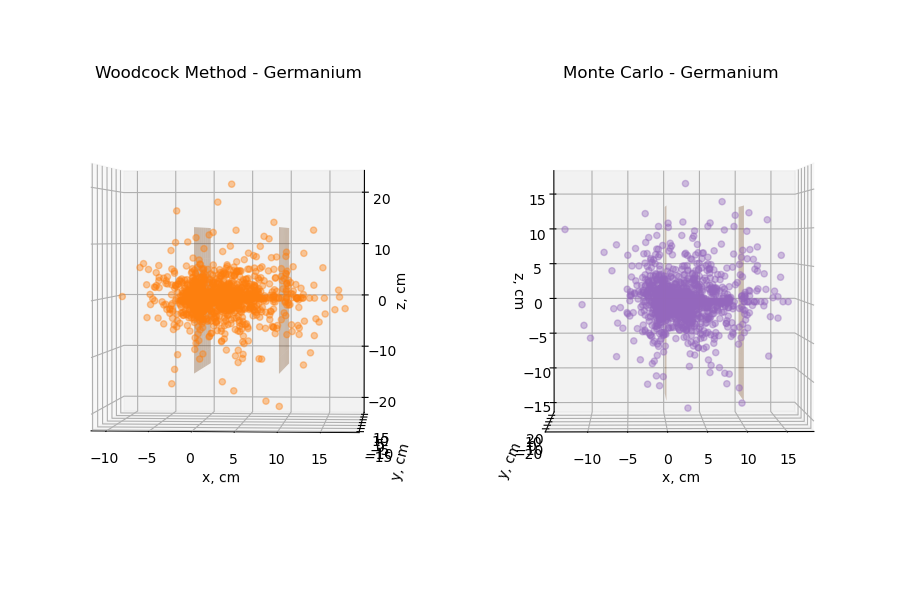

In the Woodcock simulation, taking p1 to be very large, 0.0427+-0.0018 were transmitted through 10 cm of germanium,        and 0.675+-0.011 were absorbed.
In the  Monte Carlo simulation, 0.0415+-0.0011 were transmitted through 10 cm of germanium, and 0.681+-0.0068 were absorbed.


In [58]:
path_1 = path(vacuum_approx)
path_2 = path(germanium)
path_t = np.amin([path_1, path_2]) # Finding the smaller path length

m = np.linspace(-3-l/2,3+l/2,10)
n = np.linspace(-3-l/2,3+l/2,10)
Y,Z = np.meshgrid(m,n)

l = 10 # cm, length of test box (x axis)
b = 0 # cm, boundary along the test box from subsstance 1 to 2
test_particles = 1500
runs = 5

tot_trans_wood = []
tot_abs_wood = []
tot_trans_monte = []
tot_abs_monte = []

for i in range(runs):
    N_transmit_wood = 0
    N_absorb_wood = 0
    
    final_x = []
    final_y = []
    final_z = []

    for i in range(test_particles):
        x,y,z,reason= neutron_woodcock(0, 0, 0, b, l, vacuum_approx, germanium) 

        final_x.append(x)
        final_y.append(y)
        final_z.append(z)
        if reason == "transmit":
            N_transmit_wood += 1
        if reason == "absorb2":
            N_absorb_wood += 1
    tot_trans_wood.append(N_transmit_wood/test_particles)
    tot_abs_wood.append(N_absorb_wood/test_particles)        

fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(1,2,1, projection="3d")
ax1.set_box_aspect((1, 1, 1))
ax1.scatter(final_x, final_y, final_z, color=colours[9], alpha=0.4)

ax1.set_title("Woodcock Method - Germanium")
ax1.set_xlabel("x, cm")
ax1.set_ylabel("y, cm")
ax1.set_zlabel("z, cm")
ax1.plot_surface(b,Y, Z, alpha=0.3, color=colours[9])
ax1.plot_surface(l,Y, Z, alpha=0.3, color=colours[9])

p_absorb= interaction_probs(absorb_germanium, scatter_germanium)



for i in range(runs):
    final_x = []
    final_y = []
    final_z = []
    N_transmit_monte = 0
    N_absorb_monte = 0
    
    for i in range(test_particles):
        x, y, z, reason = particle_pos_no_energy(path_2, l-b, p_absorb)
        if reason == "transmit":
            N_transmit_monte += 1
        if reason == "absorb":
            N_absorb_monte += 1
        final_x.append(x)
        final_y.append(y)
        final_z.append(z)
    tot_trans_monte.append(N_transmit_monte/test_particles)
    tot_abs_monte.append(N_absorb_monte/test_particles)
    
ax2 = fig.add_subplot(1,2,2, projection="3d")
ax2.set_box_aspect((1, 1, 1))
ax2.scatter(final_x, final_y, final_z, color=colours[8], alpha=0.4)

ax2.set_title("Monte Carlo - Germanium")
ax2.set_xlabel("x, cm")
ax2.set_ylabel("y, cm")
ax2.set_zlabel("z, cm")
ax2.plot_surface(b,Y, Z, alpha=0.3, color=colours[9])
ax2.plot_surface(l,Y, Z, alpha=0.3, color=colours[9])

print("In the Woodcock simulation, taking p1 to be very large, {:.3}+-{:.2} were transmitted through 10 cm of germanium, \
       and {:.3}+-{:.2} were absorbed.".format(np.mean(tot_trans_wood), np.std(tot_trans_wood), 
                                              np.mean(tot_abs_wood), np.std(tot_abs_wood)))
print("In the  Monte Carlo simulation, {:.3}+-{:.2} were transmitted through 10 cm of germanium, and {:.3}+-{:.2} were absorbed.".\
      format(np.mean(tot_trans_monte), np.std(tot_trans_monte), np.mean(tot_abs_monte), np.std(tot_abs_monte)))

fig.tight_layout()

<IPython.core.display.Javascript object>


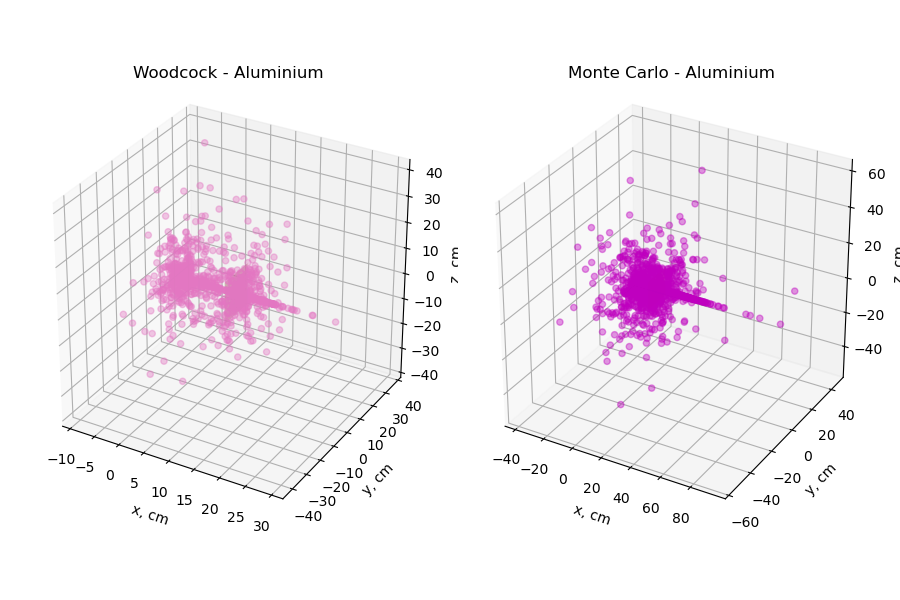

In the Woodcock simulation, taking p1 to be very large, 0.565+-0.013 were transmitted through 10 cm of aluminium, and 0.183+-0.0067 were absorbed.
In the  Monte Carlo simulation, 0.558+-0.013 were transmitted through 10 cm of aluminium, and 0.192+-0.019 were absorbed.


In [59]:
path_1 = path(aluminium)
path_2 = path(germanium)
path_t = np.amin([path_1, path_2]) # Finding the smaller path length

m = np.linspace(-3-l/2,3+l/2,10)
n = np.linspace(-3-l/2,3+l/2,10)
Y,Z = np.meshgrid(m,n)

l = 10 # cm, length of test box (x axis)
b = 10 # cm, boundary along the test box from subsstance 1 to 2
test_particles = 1500
runs = 5

tot_trans_wood_al = []
tot_trans_monte_al = []
tot_abs_wood_al = []
tot_abs_monte_al = []

for i in range(runs):
    N_transmit_wood_al = 0
    N_absorb_wood_al = 0
    
    final_x = []
    final_y = []
    final_z = []

    for i in range(test_particles):
        x, y, z, reason = neutron_woodcock(0, 0, 0, b, l, aluminium, germanium) 

        if reason == "transmit":
            N_transmit_wood_al += 1
        if reason == "absorb1":
            N_absorb_wood_al += 1
        final_x.append(x)
        final_y.append(y)
        final_z.append(z)
    tot_trans_wood_al.append(N_transmit_wood_al/test_particles)
    tot_abs_wood_al.append(N_absorb_wood_al/test_particles)

fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(1,2,1, projection="3d")
ax1.set_box_aspect((1, 1, 1))
ax1.scatter(final_x, final_y, final_z, color=colours[6], alpha=0.4)

ax1.set_title("Woodcock - Aluminium")
ax1.set_xlabel("x, cm")
ax1.set_ylabel("y, cm")
ax1.set_zlabel("z, cm")
ax1.plot_surface(l,Y, Z, alpha=0.3, color=colours[9])



p_absorb= interaction_probs(absorb_aluminium, scatter_aluminium)

for i in range(runs):
    N_transmit_monte_al = 0
    N_absorb_monte_al = 0
    
    final_x = []
    final_y = []
    final_z = []

    for i in range(test_particles):
        x, y, z, reason = particle_pos_no_energy(path_1, l, p_absorb)
        if reason == "transmit":
            N_transmit_monte_al += 1
        if reason == "absorb":
            N_absorb_monte_al += 1
        final_x.append(x)
        final_y.append(y)
        final_z.append(z)
    tot_trans_monte_al.append(N_transmit_monte_al/test_particles)
    tot_abs_monte_al.append(N_absorb_monte_al/test_particles)

ax2 = fig.add_subplot(1,2,2, projection="3d")
ax2.set_box_aspect((1, 1, 1))
ax2.scatter(final_x, final_y, final_z, color=colours[5], alpha=0.4)

ax2.set_title("Monte Carlo - Aluminium")
ax2.set_xlabel("x, cm")
ax2.set_ylabel("y, cm")
ax2.set_zlabel("z, cm")

ax2.plot_surface(l,Y, Z, alpha=0.3, color=colours[9])

print("In the Woodcock simulation, taking p1 to be very large, {:.3}+-{:.2} were transmitted through 10 cm of aluminium, \
and {:.3}+-{:.2} were absorbed.".format(np.mean(tot_trans_wood_al), np.std(tot_trans_wood_al), 
                                              np.mean(tot_abs_wood_al), np.std(tot_abs_wood_al)))
print("In the  Monte Carlo simulation, {:.3}+-{:.2} were transmitted through 10 cm of aluminium, and {:.3}+-{:.2} were \
absorbed.".format(np.mean(tot_trans_monte_al), np.std(tot_trans_monte_al), np.mean(tot_abs_monte_al),
                       np.std(tot_abs_monte_al)))

fig.tight_layout()

The results of these tests show that the method is consistent with Monte Carlo simulations. However, one difference between the two is clear in the aluminium case. In the larger mean free path region, transmission and scattering is detected quicker in the Woodcock case than in Monte Carlo. This is because the position is checked more regularly in the Woodcock case as fictitious steps are being taken. However, in the shorter region no fictitious steps are taken so this difference does not appear.

# Calculating Transmission Through Multiple 10cm Slabs of Differing Material.

Now we have verified the reliability of the method, it can be used to simulate the properties of two interfaced materials. The case to be considered is the aluminium-germanium set up. As only the number of neutrons is required, the function is updated to only return the reason for termination. 

In [60]:
def neutron_woodcock_transmit(x, y, z, b, l, mat1, mat2):
    is_killed = False

    path_1 = path(mat1)
    path_t = path(mat2)
    x, y, z = first_woodcock([x,y,z], path_1, path_t, b, l) 
    
    while is_killed == False:
        if x<0:
            return "scatter"
        elif x>l:
            return "transmit"
        elif b<x<l:
            absorb = absorption_test(mat2[2], mat2[3]) 
            if absorb == "absorb":
                return "absorb2"
        elif 0<x<b:
            absorb = absorption_test(mat1[2], mat1[3]) 
            if absorb == "absorb":
                return "absorb1"
        x, y, z= step_woodcock([x, y, z], path_1, path_t, b, l)   

In [61]:
path_1 = path(aluminium)
path_2 = path(germanium)
path_t = np.amin([path_1, path_2]) # Finding the smaller path length

l = 20 # cm, length of test box (x axis)
b = 10 # cm, boundary along the test box from subsstance 1 to 2
test_particles = 1000
runs = 10
transmit_array = []

for i in range(runs):
    N_transmit_wood = 0
    for i in range(test_particles):
        reason= neutron_woodcock_transmit(0, 0, 0, b, l, aluminium, germanium)
        if reason == "transmit":
            N_transmit_wood += 1

    transmit_array.append(N_transmit_wood)  
transmission_ratio = np.mean(transmit_array)/test_particles, np.std(transmit_array)/test_particles       
        
print("In the Woodcock simulation of 10cm of aluminium followed by germanium, the ratio of transmitted to total \
neutrons was {:.3}+-{:.2}".format(transmission_ratio[0], transmission_ratio[1]))

In the Woodcock simulation of 10cm of aluminium followed by germanium, the ratio of transmitted to total neutrons was 0.0226+-0.0042


The prior single material measurements indicated that the aluminium would reduce incident neutrons onto the germanium by around 55%, so an estimate of the final transmission ratio would be $0.55\times0.04=0.022$.  As the neutrons incident on the germanium were not all normal to the face, there would be slight slightly less transmission than the linear combination, but this does not 

## References
1. What is Monte Carlo Simulation? [Internet]. Ibm.com. 2021 [cited 6 May 2021]. Available from: https://www.ibm.com/cloud/learn/monte-carlo-simulation
2. Neutron Matter Interaction [Internet]. Paul Scherrer Institut (PSI). 2021 [cited 6 May 2021]. Available from: https://www.psi.ch/en/niag/neutron-interaction-with-matter
3. How radiation damages tissue [Internet]. Web.pa.msu.edu. 2021 [cited 6 May 2021]. Available from: https://web.pa.msu.edu/courses/2000fall/PHY232/lectures/radioactive/damage.html
4. Neutron scattering lengths and cross sections [Internet]. Ncnr.nist.gov. 2021 [cited 6 May 2021].  https://www.ncnr.nist.gov/resources/n-lengths/
5. Mean Free Path [Internet]. Nuclear-power.net. 2021 [cited 7 May 2021]. Available from: https://www.nuclear-power.net/nuclear-power/reactor-physics/nuclear-engineering-fundamentals/neutron-nuclear-reactions/mean-free-path/
6. Central Limit Theorem: Definition and Examples in Easy Steps - Statistics How To [Internet]. Statistics How To. 2021 [cited 7 May 2021]. Available from: https://www.statisticshowto.com/probability-and-statistics/normal-distributions/central-limit-theorem-definition-examples/
7. scipy.stats.maxwell — SciPy v1.6.3 Reference Guide [Internet]. Docs.scipy.org. 2021 [cited 7 May 2021]. Available from: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.maxwell.html
8. g. Islam, A.F., Modeling Neutron Interaction Inside a 2D Reactor Using Monte Carlo Method. (Master's thesis). 2019. [cited 7 May 2021]. Available from: https://scholarcommons.sc.edu/etd/5579 
9. Shahmohammadi Beni M, Hau T, Krstic D, Nikezic D, Yu K. Monte Carlo studies on neutron interactions in radiobiological experiments. PLOS ONE. 2017;12(7):e0181281.